# Setup

Game: https://gym.openai.com/envs/Acrobot-v1/

In [1]:
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

import random
import numpy as np

import gym

In [2]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

# Network

In [3]:
GAMMA = 0.5
ALPHA = 0.5
LR = 0.05
EPSILON = 0.99
EPS_DECAY = 0.95

class DQN:

    def __init__(self, observation_space, action_space):
        
        self.epsilon = EPSILON
        self.alpha = ALPHA
        self.gamma = GAMMA
        self.action_space = action_space
        self.observation_space = observation_space
        
        self.memory = []
        self.batch_size = 128

        # MODEL
        self.model = Sequential()
        self.model.add(Dense(16, input_shape=(observation_space,), kernel_initializer='he_normal'))
        self.model.add(LeakyReLU(0.1))
        self.model.add(Dense(32, kernel_initializer='he_normal'))
        self.model.add(LeakyReLU(0.1))
        self.model.add(Dense(8, kernel_initializer='he_normal'))
        self.model.add(LeakyReLU(0.2))
        self.model.add(Dropout(0.25))
        self.model.add(BatchNormalization())
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LR))
        
    def act(self, state):
        if np.random.rand() < self.epsilon:
            # print("RANDOM!")
            return random.randrange(self.action_space)
        q = self.model.predict(state)
        print("Measured: " + str(q[0]), state,np.argmax(q[0]))
        return np.argmax(q[0])

    def experience_replay(self):
        # print(self.memory,self.batch_size)
        import pandas as pd

        mem_sample = random.sample(self.memory, min(len(self.memory),self.batch_size))

        for state, action, reward, next_state, done in mem_sample:
            # print(state, action, reward, next_state, done)
            update_value = reward
            # print(update_value)
            if not done:
                # print("Discounting")
                update_value = self.alpha * (reward + self.gamma * np.max(self.model.predict(next_state)[0]))
            q = self.model.predict(state)
            if(update_value!=0):
                q[0][action] = update_value
            # print(state,type(state))
            # print(state,next_state,action,reward,q,done)
            self.model.train_on_batch(np.array(state), q)
        self.epsilon *= EPS_DECAY
        print("Epsilon: " + str(self.epsilon))

        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

# Run & Train

In [4]:
scores = []
STEPS = 50

def run_game():
    env = gym.make("Acrobot-v1")
    env.seed(21)
    observation_space, action_space = env.observation_space.shape[0], env.action_space.n
    dqn = DQN(observation_space, action_space)
    
    for step in range(STEPS):
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        done = False
        # Run until you reach the horizontal line
        while not done:
            # Save images
            env.render(mode="rgb_array")
            score -= 1 # Lower score is better as we reach the horizontal line faster
            
            # Get action based on netwroks
            action = dqn.act(state)
            next_state, reward, done, info = env.step(action)
            reward = reward if not done else -reward
            next_state = np.reshape(next_state, [1, observation_space])
            
            state = next_state
            dqn.remember(state, action, reward, next_state, done)
            
        # Learn from each run
        # Moving this inside the while loop gives better results but much slower speed as we train at each frame
        dqn.experience_replay()
            
        scores.append(score)
        print ("Round: " + str(step) + " Score: " + str(score))
    return dqn, scores

In [5]:
dqn, scores = run_game()

Measured: [0.32055688 0.56171364 0.75022244] [[ 0.99237829  0.12322881  0.92377674 -0.3829315  -0.0390826  -0.16645478]] 2
Measured: [0.4695383  0.8488374  0.91896445] [[ 0.97543436  0.22029026  0.67801911 -0.73504427  0.3370401  -0.45102335]] 2
Measured: [0.9132054 1.3695935 1.8632516] [[ 0.91642216  0.40021298  0.99992232  0.01246387  1.02223653 -3.14307956]] 2
Measured: [ 0.20617959  0.03136691 -0.23756476] [[ 0.7611077  -0.64862553  0.84720003  0.53127405  0.03331402  1.64630473]] 0
Measured: [-0.08462378  0.25366747 -0.43505347] [[ 0.89773655 -0.44053272 -0.34878919  0.93720121  0.46855222 -0.17307365]] 1
Epsilon: 0.9405
Round: 0 Score: -500
Measured: [-0.6504015  -0.5964201   0.34257123] [[ 0.99927779 -0.0379987   0.9805469   0.19628495 -0.06019237  0.46325001]] 2
Measured: [-1.0313053  -0.29466367  0.66666055] [[ 0.99336771 -0.1149808   0.99719422  0.07485776  0.29360463 -1.18716622]] 2
Measured: [-0.7892263  -0.5109008   0.27718073] [[ 0.96051633 -0.27822362  0.97425836  0.2254

Measured: [-0.6023291   0.5543512   0.68497586] [[ 0.90948537 -0.41573592  0.8874022  -0.46099603 -1.13412035  1.38221094]] 2
Measured: [-0.16569498  0.54545176  0.1458284 ] [[ 0.98648673 -0.16384117  0.46534527  0.88512925 -1.10634592 -0.21855041]] 1
Measured: [-0.6110201 -1.2892132 -1.0536023] [[ 0.97874694  0.20507174 -0.33831599 -0.94103257  0.61140626 -1.83464046]] 0
Measured: [-0.36742565 -0.26210728 -1.7739779 ] [[ 0.95308336  0.30270795 -0.59061312 -0.80695486  0.38943    -1.0372711 ]] 1
Measured: [-0.4015639  -0.81437016 -0.4509208 ] [[ 0.84394976  0.53642223  0.70872748  0.70548236  0.70939482 -1.77181248]] 0
Measured: [-0.40709627 -1.0796767  -0.09394842] [[ 0.78952887  0.61371342  0.92153664  0.3882914   0.22398602 -2.03059428]] 2
Measured: [-0.26393315 -0.51836693  0.23717657] [[ 0.66423555 -0.74752333  0.98443587 -0.1757442   0.03485998 -0.33186691]] 2
Measured: [-0.43561852 -0.9102342  -0.44653267] [[ 0.99203191  0.12598689  0.87491648 -0.48427384  1.56351206  0.44864316

Measured: [ 7.4553356 16.169497   5.3720045] [[ 0.99936355  0.03567199  0.99927664 -0.03802897  0.20756704 -0.88280654]] 1
Measured: [ 5.4120755 16.36967    5.268491 ] [[ 0.99600933  0.08924914  0.87301028 -0.4877018  -0.17589095  0.06184038]] 1
Measured: [1.6054276 7.9984913 1.9849837] [[ 0.99966267 -0.02597213  0.9512     -0.30857505 -0.2770488   0.64796942]] 1
Measured: [ 5.790452   11.955186    0.98882985] [[ 0.9985996   0.05290412  0.9998054  -0.01972695  0.45084601 -0.40170805]] 1
Measured: [ 4.8969193 14.774406   4.191537 ] [[ 0.98095514  0.19423441  0.98988378 -0.14188058 -0.17456559  0.37311799]] 1
Measured: [ 5.4423933 13.000197   4.127284 ] [[ 0.96987601 -0.24359909  0.89855364  0.43886371  0.3311028  -0.8789855 ]] 1
Measured: [ 9.247009 28.699078 21.237434] [[ 0.98942093 -0.14507318  0.97633259  0.21627455  0.6479017  -1.43348759]] 1
Measured: [ 6.7099514 21.65827   10.856063 ] [[ 0.95604809  0.29320992  0.74999473 -0.6614438   0.10052168 -0.33436923]] 1
Measured: [ 3.74482

Measured: [23.801458 72.954636 68.122406] [[ 0.77937211  0.62656134  0.94588408 -0.3245047   2.367204   -3.47108581]] 1
Measured: [15.886965 51.75004  43.56655 ] [[ 0.49942362  0.86635792  0.62722831 -0.77883544  1.28907698 -2.08978862]] 1
Measured: [-6.854996  -7.1966    -7.0558376] [[ 0.4859519   0.87398556  0.43284491 -0.9014684  -1.25810605  1.09553906]] 0
Measured: [-24.44517  -41.42957   -7.348583] [[ 0.98490501  0.17309569  0.991335   -0.13135795 -3.02476718  3.87217127]] 2
Measured: [-21.055855 -49.32082  -16.017918] [[ 0.90699906 -0.42113265  0.79898689  0.60134845 -2.90284554  3.58319753]] 2
Measured: [21.44567 66.65602 72.4559 ] [[ 0.79457408 -0.60716722  0.90997039  0.41467323  2.78283487 -4.20862619]] 2
Measured: [29.103682 90.76804  91.58383 ] [[ 0.99871847 -0.05061046  0.90325458 -0.42910508  3.07055938 -4.15328492]] 2
Measured: [-29.815695 -50.319817 -16.006636] [[ 0.69320979  0.72073587  0.88974573 -0.4564565  -2.18096753  4.21680878]] 2
Measured: [-29.619398 -63.57646

Measured: [-2.1342926  2.990183  14.779536 ] [[ 0.87569219 -0.48286973  0.97115601  0.23844498  0.79450124 -1.29172076]] 2
Measured: [-2.496212   4.8654237 21.88534  ] [[ 0.99902996 -0.04403573  0.94624725 -0.3234442   1.35042529 -1.37569772]] 2
Measured: [0.83845246 4.822515   8.6439085 ] [[ 0.98018192  0.1980995   0.86828295 -0.49606928  1.031397   -0.45869452]] 2
Measured: [-1.3817012 -1.406913  -4.7179546] [[ 0.99988773  0.01498451  0.73001161  0.68343474 -0.76833393  1.17560939]] 0
Measured: [1.471023  4.7995834 3.1995373] [[ 0.98511568  0.1718927   0.5291136  -0.848551   -0.04086208 -0.13362639]] 1
Measured: [-3.5316586  5.2701206  5.9589725] [[ 0.99773603 -0.06725191  0.94150415 -0.3370014  -0.53392313  1.85178297]] 2
Measured: [-0.98976123 -0.2100442  -6.467579  ] [[ 0.96677769 -0.25561868  0.88745007  0.46090386 -0.19273612  1.69731156]] 1
Measured: [2.5566535 4.5753384 4.8950057] [[ 0.90397087  0.42759403  0.96101257 -0.27650469  0.00847808 -0.8936393 ]] 2
Measured: [1.42506 

Measured: [  5.904352    0.7729811 -10.776334 ] [[ 0.96914397 -0.24649538  0.99346404  0.1141455   0.33522695  0.26577187]] 0
Measured: [ 3.786043   1.4783503 -0.9780543] [[ 0.99036041 -0.13851448  0.99511594  0.09871301  0.74284153 -0.40153013]] 0
Measured: [-2.2938054  1.0392563 11.061329 ] [[ 0.97467446  0.22362846  0.97662028 -0.21497169  0.90500658 -0.9373896 ]] 2
Measured: [-8.584398  -2.2580247  4.2851186] [[ 0.99628793  0.0860834   0.94549172  0.32564614 -1.01050802  1.69178593]] 2
Measured: [0.32158938 0.86666566 1.2893898 ] [[ 0.94019488 -0.34063704  0.53507556  0.8448042   1.06818528 -0.67279223]] 2
Measured: [-12.348979   -3.0362144   6.6642504] [[ 0.92240766  0.38621769  0.92651324 -0.37626217 -1.23193926  0.99752994]] 2
Measured: [-7.920669   3.7106237 44.792496 ] [[ 0.97782129 -0.20944097  0.99700883 -0.07728768  1.83425375 -2.66166389]] 2
Measured: [-4.3695107  0.5621164 11.766158 ] [[ 0.91127399  0.41180058  0.69513894 -0.71887541  1.06307183 -0.56902099]] 2
Measured: 

Measured: [-4.062559   -3.8824859  -0.74686265] [[ 0.99292118 -0.1187751   0.97821642  0.20758764 -0.84612293  1.29177216]] 2
Measured: [  7.7950096   2.414906  -10.477081 ] [[ 0.93106519 -0.36485285  0.81216153  0.58343265 -0.30373876  0.57911117]] 0
Measured: [-1.6477978  7.4993997 26.409851 ] [[ 0.99834811 -0.05745477  0.99679421  0.08000819  0.94811225 -1.55060946]] 2
Measured: [-0.84564126  0.6291214   2.3583932 ] [[ 0.97049679  0.24111405  0.93304739 -0.35975348  0.47411619 -0.61597559]] 2
Measured: [-1.5488406 -1.8817253 -4.2267084] [[ 0.95948856  0.28174759  0.92383397 -0.38279341 -0.06120233  0.37515804]] 0
Measured: [ 4.454015   3.4024403 -3.4656918] [[ 0.97945482 -0.20166374  0.9463898   0.32302684  0.26279476 -0.59764063]] 0
Measured: [-1.8619163  7.8178253 28.251368 ] [[ 0.99914121  0.04143483  0.98273069 -0.18504158  0.82282331 -1.71372924]] 2
Measured: [-2.0276074  1.6301178  8.037402 ] [[ 0.9847271   0.17410495  0.89892648 -0.4380995   0.48119084 -0.90216692]] 2
Measure

Measured: [-9.973206 -6.870122 -9.811738] [[ 0.9994989  -0.0316536   0.99998098 -0.00616831 -0.44778036  0.54239023]] 1
Measured: [ -9.853249  -7.436145 -13.838159] [[ 0.99361329 -0.11283896  0.9956474   0.0932001  -0.3470034   0.42312656]] 1
Measured: [-11.485285  -9.45989  -20.762173] [[ 0.98663377 -0.1629534   0.98834298  0.15224372 -0.14738141  0.15479422]] 1
Measured: [-13.09617  -11.337938 -25.25553 ] [[ 0.99822257 -0.0595961   0.99206348  0.12573802  0.20006727  0.15378237]] 1
Measured: [-12.844675 -11.045154 -24.389341] [[0.99950732 0.03138657 0.9881188  0.15369204 0.1487452  0.18621429]] 1
Measured: [-12.343298 -10.745678 -24.31137 ] [[ 0.99630308  0.08590792  0.9881675   0.15337856 -0.00246358 -0.15799886]] 1
Measured: [ -8.671782  -6.551944 -11.054198] [[ 0.99883608 -0.04823364  0.97093779 -0.23933201  0.13038701 -0.51725364]] 1
Measured: [-12.895016 -10.081792 -17.78724 ] [[ 0.99988877 -0.01491472  0.95337399 -0.30179137 -0.04911168  0.39950905]] 1
Measured: [-13.646494 -11

Measured: [ 3.5177143  5.9816084 19.514376 ] [[ 0.97245706  0.23308208  0.94059988 -0.33951712 -1.40768938  2.42081135]] 2
Measured: [8.757336   7.147087   0.65458465] [[ 0.93319001 -0.35938336  0.76772067  0.64078466 -1.13974852  1.82606718]] 0
Measured: [-2.2567372 -1.6333764 -7.7570267] [[ 0.86727034 -0.49783748  0.64561594  0.76366227  0.36297537 -0.83737942]] 1
Measured: [35.72692  30.941658 68.38565 ] [[ 0.993598   -0.1129735   0.99643976  0.08430777  1.56488309 -2.95898635]] 2
Measured: [27.494078 25.273441 59.979465] [[ 0.98312996  0.18290841  0.8968891  -0.44225551  1.32612267 -2.31334874]] 2
Measured: [3.02871   3.9015648 5.588399 ] [[ 0.98027482 -0.19763926  0.91673161  0.39950364 -1.08794878  1.96636538]] 2
Measured: [ 7.506836   5.1841755 -4.032342 ] [[ 0.92650962 -0.37627108  0.72873527  0.68479552 -0.73897677  1.39854054]] 0
Measured: [26.671995 23.386965 51.30282 ] [[ 0.98558117 -0.16920332  0.94735644  0.32018085  1.34365279 -2.6559524 ]] 2
Measured: [ 1.809354  4.4935

Measured: [-34.696293  -16.569174    7.6940937] [[ 0.94023233 -0.34053366  0.97705216  0.21300019 -2.07791699  5.04246183]] 2
Measured: [-36.778862 -27.61063  -13.216189] [[ 0.7718243  -0.63583586  0.43264629  0.90156374 -1.23798898  3.86517621]] 2
Measured: [-21.138247 -25.046524 -25.099842] [[ 0.67646905 -0.73647106 -0.1725703   0.9849972  -0.14867029  2.35477061]] 0
Measured: [ -7.0116386 -17.521477  -18.479923 ] [[ 0.73748641 -0.67536198 -0.44115362  0.8974316   0.96955649  0.50499065]] 0
Measured: [-10.588888  -20.016928  -14.7897215] [[ 0.79968646  0.60041783  0.43054444 -0.90256938 -2.04706334  0.77743652]] 0
Measured: [-15.26222   -11.248476    3.1752732] [[ 0.98567184  0.16867432  0.67418738 -0.73856034 -2.60550389  2.09989338]] 2
Measured: [-23.893345   -4.0278697  17.589376 ] [[ 0.9294441  -0.36896297  0.96213063 -0.2725888  -2.74819753  3.2517669 ]] 2
Measured: [ 4.4536877 11.577574   5.5028915] [[ 0.38192879 -0.92419175  0.6944023   0.719587   -0.84737769  1.34471766]] 1
M

Measured: [-35.645428 -53.662952 -23.172354] [[ 0.98496863  0.17273333  0.99992351 -0.01236851 -0.06116804  0.40792704]] 2
Measured: [12.495351  10.577948   2.0007653] [[ 0.99182695  0.12759036  0.99311588  0.11713607 -0.38166514  0.85943964]] 0
Measured: [ -8.386802 -18.491566 -15.436101] [[ 0.99425344 -0.10705185  0.91326761  0.40736012 -0.41312757  0.35412644]] 0
Measured: [-35.70357  -52.605137 -31.056171] [[ 0.98826069 -0.15277697  0.92060474  0.39049574 -0.03873062 -0.5418598 ]] 2
Measured: [-38.97262  -53.8595   -22.912966] [[ 0.99242519 -0.12285047  0.99113692  0.13284431  0.15920673 -0.69447066]] 2
Measured: [-40.9903   -57.871693 -24.665087] [[ 0.99601567 -0.08917839  0.99995648  0.0093289   0.16849627 -0.51779272]] 2
Measured: [-42.487633 -62.867153 -28.757267] [[ 0.99820567 -0.05987855  0.99792669 -0.06436089  0.11725742 -0.20269718]] 2
Measured: [-43.55233  -64.79691  -29.980164] [[ 0.99977238 -0.02133524  0.99789574 -0.06483892  0.19974678 -0.14604483]] 2
Measured: [-41.1

Measured: [-19.913101 -11.041844  17.905859] [[ 0.97944884  0.20169278  0.99567005 -0.09295776  1.05839136 -1.67190311]] 2
Measured: [20.160215  19.08438    2.2202976] [[ 0.92459283 -0.38095682  0.87080324  0.49163169 -0.77862063  1.0472359 ]] 0
Measured: [-11.88133    -6.1763687   9.349522 ] [[ 0.92017327 -0.39151137  0.91074492  0.41296936  0.72611758 -1.47096449]] 2
Measured: [-9.478278   3.5617492 23.95828  ] [[ 0.97557597 -0.21966231  0.99511763  0.09869601  1.03585807 -1.71545682]] 2
Measured: [-20.883963 -14.464372  14.865149] [[ 0.99995252 -0.00974414  0.97555225 -0.2197676   1.02795377 -1.39665542]] 2
Measured: [-37.425095 -54.123665 -18.144808] [[ 0.94904295  0.31514677  0.91166169 -0.41094157  0.03564458  0.48746306]] 2
Measured: [45.8633   53.38992  19.205332] [[ 0.96401635  0.26584295  0.97487051 -0.22277227 -0.536908    1.46540246]] 1
Measured: [38.013416 42.70532  13.833973] [[ 0.99941592 -0.03417346  0.90826716  0.4183907  -0.80440803  1.47162204]] 1
Measured: [ 8.87262

Measured: [ -5.451346 -16.711006  -8.016224] [[ 0.99494112 -0.10045981  0.98178536 -0.18999346 -0.17886899  0.1246081 ]] 0
Measured: [ -7.172179  -18.590683   -7.6232185] [[ 0.99364435 -0.11256514  0.98157938 -0.19105475  0.05928549 -0.13678398]] 0
Measured: [ -8.611278  -16.680973   -2.3425462] [[ 0.99694482 -0.0781091   0.9705551  -0.2408792   0.27803819 -0.35887148]] 2
Measured: [ -6.4195833 -18.630009   -6.882948 ] [[ 0.99945057 -0.03314438  0.96648094 -0.25673837  0.16277261  0.20449014]] 0
Measured: [ -6.7674084 -19.35598    -7.273597 ] [[ 0.99994296  0.01068072  0.97376726 -0.22754629  0.2673769   0.09856143]] 0
Measured: [ 17.925076    6.7473083 -16.714943 ] [[ 0.9967976   0.07996589  0.99924767  0.03878267 -0.24618668  1.17488053]] 0
Measured: [ -6.847308 -19.492325 -17.73641 ] [[ 0.99999162  0.00409367  0.93246044  0.3612721   0.06551683 -0.26830371]] 0
Measured: [-10.877547  -16.5042     -2.8970597] [[ 0.99775769  0.06692978  0.99659115  0.08249891  0.06836067 -0.69683688]] 

Measured: [ -8.884296 -17.514362  -4.802948] [[ 0.99887417 -0.04743833  0.99909567 -0.04251881  0.10319725 -0.34482086]] 2
Measured: [ -7.0132227 -18.721146   -8.592199 ] [[ 0.99947465 -0.0324103   0.99801466 -0.06298209  0.03469007  0.07461641]] 0
Measured: [ -7.079237  -18.956272   -7.2628603] [[ 0.99871327  0.0507129   0.99252859 -0.12201233  0.0861801   0.04793178]] 0
Measured: [ -7.4461594 -19.300686   -7.1211405] [[ 0.99739871  0.072082    0.99162882 -0.12912121  0.12330224 -0.11492276]] 2
Measured: [ -3.6711254 -15.150886   -8.318979 ] [[ 0.99745847  0.07125029  0.9953183  -0.0966513  -0.13023684  0.4355519 ]] 0
Measured: [ -6.271154 -17.830563  -8.32867 ] [[ 0.99876554  0.04967286  0.99951078 -0.03127622 -0.0795516   0.20513756]] 0
Measured: [ -7.5216675 -18.94357    -8.110476 ] [[ 0.99914486  0.04134657  0.99982528 -0.01869259 -0.00185875 -0.08242175]] 0
Measured: [ 12.009574    1.9825957 -16.47784  ] [[ 0.98844918 -0.1515527   0.95630834  0.29235997 -0.34076948  0.83196978]] 

Measured: [  3.7741227 -10.580519  -17.299015 ] [[ 0.99349825 -0.1138474   0.9744566   0.2245759  -0.35228454  0.29663175]] 0
Measured: [-13.627999   -2.0232933  24.985168 ] [[ 0.99969308 -0.02477389  0.98170102 -0.19042874  0.54909724 -1.41735462]] 2
Measured: [  4.828887 -10.585786  -4.745247] [[ 0.99469933  0.10282628  0.90364218 -0.42828823 -0.21651573  0.74719221]] 0
Measured: [ 20.690258    0.3630215 -24.376438 ] [[ 0.99998994 -0.0044851   0.99670502 -0.08111172 -0.32267329  1.0785575 ]] 0
Measured: [ -1.7530465 -18.987652  -19.561697 ] [[ 0.99776519 -0.0668179   0.9371769   0.3488545   0.12843047  0.03940425]] 0
Measured: [-10.292813  -14.433738    3.0636451] [[ 0.99988573 -0.01511714  0.95835356  0.28558439  0.37703825 -0.68890028]] 2
Measured: [ -9.718009  -17.077654   -1.5296719] [[ 0.99873388  0.05030534  0.98693868  0.16109638  0.26027278 -0.55714734]] 2
Measured: [ -2.8264236 -18.01833    -9.681689 ] [[ 0.99738711  0.07224236  0.99807882  0.06195693 -0.16605477  0.10062067

Measured: [ -8.366575  -16.699024    2.5379689] [[ 0.99462388  0.10355358  0.99283498 -0.11949351  0.074143   -0.49319367]] 2
Measured: [ -4.6261396 -19.030113   -3.0769913] [[ 0.9960129   0.08920938  0.98746079 -0.15786448 -0.21591098  0.10911272]] 2
Measured: [  1.3819643 -14.527423  -13.7558975] [[ 0.99848484 -0.05502753  0.99982655  0.0186247  -0.29378811  0.30796514]] 0
Measured: [ -4.315673 -18.79174  -10.071592] [[ 0.99588909 -0.09058099  0.99939019  0.03491773 -0.0553327  -0.15260937]] 0
Measured: [ -8.660759  -15.7462      3.1756103] [[ 0.99947882 -0.03228138  0.98773207 -0.15615815  0.23982158 -0.53873044]] 2
Measured: [ -4.5146227 -20.400364   -4.6102676] [[ 9.99999556e-01  9.42442473e-04  9.77578628e-01 -2.10570714e-01
   8.46251358e-02 -1.51915854e-03]] 0
Measured: [ -4.7962494 -20.864742   -4.4090347] [[ 0.99965175  0.02638886  0.97496278 -0.22236813  0.16422877 -0.11309025]] 2
Measured: [  4.2680674 -13.949971  -13.668583 ] [[ 0.99981319  0.01932823  0.99765686 -0.068416

Measured: [ -9.985802   -15.024726    -0.22332644] [[ 0.9962805   0.08616943  0.99988986 -0.0148417   0.30632416 -0.7247816 ]] 2
Measured: [ -8.728385  -20.973106   -2.9504905] [[ 0.99279899  0.11979217  0.9940613  -0.10882153  0.02247766 -0.19677703]] 2
Measured: [ -4.4835806 -17.133163   -3.3009057] [[ 0.99554946  0.09424046  0.99590789 -0.09037407 -0.27335715  0.37451969]] 2
Measured: [10.91479   -3.0350065 -4.883331 ] [[ 0.99987088  0.01606929  0.99947667  0.03234782 -0.48977432  0.82010886]] 0
Measured: [ -7.03866  -19.061317 -10.145569] [[ 0.99518631 -0.09800109  0.98741098  0.15817574 -0.02634193 -0.26680396]] 0
Measured: [ -9.5135     -16.772713    -0.98345375] [[ 0.99946486 -0.03271091  0.99620156 -0.08707728  0.16934547 -0.49546742]] 2
Measured: [ -7.9636087 -20.717556   -3.459681 ] [[ 0.99993111 -0.01173819  0.98999501 -0.14110234  0.03492916 -0.03668889]] 2
Measured: [ 9.438058 -5.070057 -5.707174] [[ 0.99516741 -0.09819281  0.97905826  0.20358025 -0.23028733  0.95641248]] 

Measured: [ -8.847473 -21.79803   -5.94776 ] [[ 0.98842102  0.15173626  0.97442118  0.22472954  0.73463131 -0.11533457]] 2
Measured: [  0.25791514 -14.221749    -8.571548  ] [[ 0.95584248  0.2938795   0.95256666  0.30433002 -0.06079656  0.55536513]] 0
Measured: [ -2.8719265 -16.317982  -10.312647 ] [[ 0.96393778  0.26612771  0.92827198  0.37190204 -0.22177438  0.14905217]] 0
Measured: [-11.8349085 -13.9723215  -7.2004247] [[ 0.98949629  0.14455829  0.96959422  0.24471829 -0.3466947  -0.83325078]] 2
Measured: [ -9.434266 -17.40152   -7.638577] [[ 0.99862058  0.05250659  0.99454487  0.10430969 -0.56545328 -0.58298848]] 2
Measured: [ -4.3298473 -15.090968   -6.63629  ] [[ 0.95983546 -0.28056351  0.99318359 -0.1165605  -0.36886416 -0.1983066 ]] 0
Measured: [ -8.312406  -11.43488     1.8741317] [[ 0.95222272 -0.30540446  0.97889803 -0.20434934  0.11090294 -0.68031294]] 2
Measured: [ -7.890004  -16.240261    1.0145001] [[ 0.96394344 -0.26610719  0.95196547 -0.30620538  0.28923744 -0.35235913

Measured: [ -9.841232 -10.786978   4.790827] [[ 0.9999846   0.00554948  0.94129522 -0.33758453  0.01898118 -0.29512464]] 2
Measured: [ -6.9026446 -11.203732    2.6721175] [[ 0.9999447  -0.01051642  0.94498695 -0.32710804 -0.17581764  0.40154181]] 2
Measured: [ 1.4417967e+01  1.0737419e-02 -2.3489573e+00] [[ 0.99142674 -0.13066377  0.99881257  0.04871807 -0.35399687  1.34017278]] 0
Measured: [ 0.85894275 -9.041519   -5.5875425 ] [[ 0.98611487 -0.16606466  0.96805158  0.25075115  0.00883372  0.66837406]] 0
Measured: [-11.026968   -6.893583    7.3831606] [[ 0.96920665  0.24624879  0.98979411 -0.14250479  0.33234638 -0.85249012]] 2
Measured: [ -9.563646  -12.281677    3.2480152] [[ 0.9648782   0.26269766  0.97263628 -0.23233309 -0.16716756 -0.04680021]] 2
Measured: [19.043606   4.6897306 -2.892657 ] [[ 0.9996532   0.0263339   0.99901164  0.04444936 -0.91424953  1.27024007]] 0
Measured: [ 8.793563   -0.31234217 -3.1723769 ] [[ 0.99071972 -0.13592067  0.96974332  0.24412679 -0.67420532  0.69

Measured: [ -6.045012  -11.417469   -7.6387405] [[ 0.97962103 -0.20085479  0.97406342  0.22627515 -0.09221412 -0.32544679]] 0
Measured: [-10.404362  -3.866837   6.952326] [[ 0.98411784 -0.1775164   0.99604483  0.08885206  0.3208712  -1.04041011]] 2
Measured: [ -8.377367  -12.824228    1.9362376] [[ 0.9964791   0.08384152  0.97448945 -0.22443332  0.08190537  0.34911243]] 2
Measured: [ 5.556864   -4.2719655  -0.37126017] [[ 0.99737902  0.07235389  0.99565243 -0.09314635 -0.19084608  0.95752439]] 0
Measured: [-0.05913401 -8.697897   -3.192238  ] [[ 0.99921132  0.03970804  0.99737983  0.07234274 -0.12396307  0.66527614]] 0
Measured: [-1.7545621 -9.767654  -5.551503 ] [[ 0.99991583  0.01297417  0.9752025   0.22131445 -0.12910592  0.3855717 ]] 0
Measured: [-10.422123   -11.083044     0.78735137] [[ 0.99863207  0.05228763  0.99975369  0.02219384  0.02439505 -0.44174856]] 2
Measured: [ -8.588375   -12.5567875   -0.63871217] [[ 0.99930728  0.03721492  0.99965955 -0.02609186 -0.17345669 -0.03564

Measured: [ 0.71694815 -9.531585   -4.446883  ] [[0.99947397 0.0324312  0.96060257 0.27792571 0.0983844  0.64454625]] 0
Measured: [-7.7959805 -8.922814  -2.2668755] [[ 0.99569733  0.0926651   0.99298978  0.11820022 -0.14726289 -0.58871262]] 2
Measured: [ -5.9055605 -11.180368   -3.5128262] [[ 0.99913141  0.0416705   0.99941406  0.03422771 -0.356254   -0.24713239]] 2
Measured: [ 1.2204851 -6.6160336 -2.9242232] [[ 0.98939527 -0.14524807  0.99822579  0.05954227 -0.50078259  0.30359943]] 0
Measured: [ -4.022436  -10.284693   -5.3397894] [[ 0.9781499  -0.20790087  0.99812591  0.06119376 -0.1235854  -0.29588172]] 0
Measured: [-6.809414  -4.1298923  3.142025 ] [[ 0.9812685  -0.19264512  0.99841354 -0.0563064   0.27191385 -0.85638317]] 2
Measured: [ -6.9394674 -11.70292     1.0951335] [[ 0.99722121 -0.07449735  0.96757663 -0.25257764  0.26423471 -0.0342624 ]] 2
Measured: [ 3.9839308 -7.1162796 -1.2521489] [[ 0.99991633 -0.01293605  0.99001089  0.14099093  0.03919039  0.92820604]] 0
Measured: 

Measured: [ -6.4496365  -10.457026    -0.43660975] [[ 0.99959116 -0.02859205  0.99400566 -0.10932863 -0.28058172 -0.17777101]] 2
Measured: [-2.270807 -9.188327 -1.623225] [[ 0.99554369 -0.09430142  0.99473493 -0.10248128 -0.36400277  0.23472813]] 2
Measured: [ 3.2478495 -5.827639  -1.0274422] [[ 0.98598343 -0.16684326  0.99972392 -0.02349645 -0.35069042  0.53195961]] 0
Measured: [ -3.1263225 -10.696198   -4.700095 ] [[ 0.97984057 -0.19978102  0.99955695  0.02976413  0.02346044 -0.01262433]] 0
Measured: [-7.0507326 -7.3157663  1.0230546] [[ 0.98745341 -0.15791063  0.99960177 -0.02821866  0.39140437 -0.55013577]] 2
Measured: [ -7.48892   -11.329387    0.9300401] [[ 0.99999613  0.00278217  0.98909511 -0.14727821  0.41023338 -0.13217062]] 2
Measured: [ -6.3767185 -11.691702    1.0950077] [[ 0.99789412  0.06486386  0.99270518 -0.12056713  0.19933822  0.40618796]] 2
Measured: [ 3.5890436 -5.929409   0.9958184] [[ 0.9967913   0.08004433  0.99993171  0.0116863  -0.0454452   0.89778167]] 0
Meas

Measured: [  0.49195218 -11.216649    -2.0354793 ] [[0.99961412 0.027778   0.9998745  0.01584251 0.07789935 0.50505894]] 0
Measured: [ -2.175244 -12.60867   -3.065932] [[0.99856493 0.0535545  0.99676982 0.08031137 0.17663577 0.13380421]] 0
Measured: [ -3.4718711 -11.889038   -2.2229817] [[ 0.99541035  0.09569863  0.99756938  0.06968026  0.23694634 -0.23169675]] 2
Measured: [ 4.820822  -6.9550476 -2.4283307] [[ 0.99627576  0.08622418  0.99125899  0.13193034 -0.2759672   0.51848787]] 0
Measured: [  1.1072474 -10.6553335  -5.7793417] [[ 0.99923269  0.03916675  0.98182776  0.18977422 -0.18464783  0.0512842 ]] 0
Measured: [-4.102743  -9.684631  -3.5072153] [[ 0.99987631  0.01572775  0.98882015  0.14911308 -0.04616979 -0.46061916]] 2
Measured: [ -1.5282655 -11.374133   -4.4703264] [[ 0.99998213 -0.00597875  0.9967557   0.08048653 -0.16866086 -0.22188582]] 0
Measured: [-4.197323  -9.448298   2.6348603] [[ 0.99999852  0.0017183   0.95813717 -0.28630958 -0.04201202 -0.31951654]] 2
Measured: [ -

Measured: [  1.4063768 -10.085168   -5.938839 ] [[ 0.99059372  0.13683595  0.96353448  0.26758419 -0.24331861  0.05257361]] 0
Measured: [ -3.3301332 -11.316598   -6.31888  ] [[ 0.99577807  0.09179348  0.97342338  0.22901292 -0.2013024  -0.45249465]] 0
Measured: [-5.8316374 -4.5606947 -0.6558628] [[ 0.99823427  0.05939987  0.99571261  0.09250081 -0.12092455 -0.9139246 ]] 2
Measured: [-4.450878   -8.359998   -0.34668136] [[ 0.99986401  0.01649095  0.99851223 -0.05452827 -0.30514622 -0.53819393]] 2
Measured: [ -0.566211  -10.073177   -2.1873806] [[ 0.99825024 -0.05913087  0.9929747  -0.11832686 -0.43773054 -0.10344708]] 0
Measured: [-3.7552578  -8.932687    0.12998915] [[ 0.99217256 -0.12487435  0.98584692 -0.167648   -0.21121961 -0.39628332]] 2
Measured: [-3.7836325 -9.440115   1.0626569] [[ 0.98448677 -0.17545883  0.97275945 -0.23181683  0.1127376  -0.28429492]] 2
Measured: [ -1.9464004  -12.003531    -0.36894298] [[ 0.98864201 -0.15028966  0.96956702 -0.24482606  0.13684048  0.15644279

Measured: [ 3.0365357 -8.812275   2.8647802] [[ 0.99706742  0.07652814  0.9989233  -0.04639218 -0.09870599  0.19440811]] 0
Measured: [ 2.3819132 -8.706643   2.3971274] [[ 0.9999974   0.00227917  0.99760359 -0.06918873 -0.1082383  -0.07897763]] 2
Measured: [ 6.6231966  -7.764871    0.82456374] [[ 0.99944314 -0.03336787  0.99905118 -0.04355154 -0.24006123  0.32546484]] 0
Measured: [-0.3440864 -6.7324586  4.389466 ] [[ 0.99988115 -0.01541718  0.98989045 -0.14183403  0.18131706 -0.34541674]] 2
Measured: [ 3.2855124 -9.289506   3.4528205] [[ 0.9999874   0.00502004  0.98713512 -0.15988828  0.01866725  0.16836922]] 2
Measured: [ 9.585438  -6.7018666  2.08115  ] [[ 0.99996821 -0.00797303  0.99705046 -0.07674877 -0.14341955  0.6528501 ]] 0
Measured: [ 5.310996   -9.117457    0.41386652] [[ 0.999761   -0.02186182  0.99977491  0.02121646  0.01031455  0.30869997]] 0
Measured: [ 2.5186415 -9.683379   0.8112254] [[ 0.99999494 -0.00318045  0.99910244  0.04235932  0.17310818 -0.09742303]] 0
Measured: 

Measured: [ 6.4074755 -8.176528  -2.8429549] [[ 0.99297186 -0.11835068  0.98292272  0.18401884 -0.05126347  0.07798075]] 0
Measured: [-2.2417905 -5.417276   1.6231472] [[ 0.99525202 -0.09733152  0.99076602  0.13558278  0.25677747 -0.55695175]] 2
Measured: [ 2.6210747 -9.517744   1.3399758] [[ 0.99993322 -0.0115569   0.99999768 -0.00215598  0.12771727 -0.05659533]] 0
Measured: [ 6.214876  -8.507499  -1.2136862] [[ 0.9999888  -0.00473268  0.99271943  0.12044972 -0.09775573  0.18827704]] 0
Measured: [ 1.0700457  -8.620301    0.18421388] [[ 0.99997373 -0.00724861  0.99401458  0.1092475   0.07254819 -0.29906235]] 0
Measured: [ 6.509131  -7.4635663  2.2744634] [[ 0.99993974  0.01097824  0.99484487 -0.10140854 -0.25593538  0.40565036]] 0
Measured: [ 4.2257376 -9.059043   2.101789 ] [[ 0.99977571 -0.02117871  0.99641798 -0.08456486 -0.05980945  0.27251577]] 0
Measured: [ 2.8536837 -9.435229   2.1709576] [[ 9.99999882e-01  4.84816367e-04  9.98178543e-01 -6.03290736e-02
   9.03527675e-02  2.7224

Measured: [-0.44220066 -4.948639    3.350553  ] [[ 0.99883137  0.04833103  0.99969996  0.02449471 -0.12960301 -0.4036152 ]] 2
Measured: [ 4.133319  -5.119441   3.7411804] [[ 0.9999907   0.00431297  0.99983764 -0.01801952 -0.30296185 -0.02138532]] 0
Measured: [-0.0079689 -4.7873964  3.8996327] [[ 0.99914266 -0.0413998   0.99842861 -0.05603846 -0.14652498 -0.35900369]] 2
Measured: [ 4.2935243 -4.8704433  4.475616 ] [[ 0.99686039 -0.07917937  0.99595292 -0.08987643 -0.22507634  0.01915541]] 2
Measured: [ 7.953173  -3.8415718  4.321876 ] [[ 0.99186054 -0.12732902  0.99867338 -0.05149251 -0.24801734  0.35140614]] 0
Measured: [ 3.6564865 -5.987812   2.880728 ] [[ 0.98921292 -0.14648478  0.9996627  -0.02597088  0.05892907 -0.10269833]] 0
Measured: [-6.607967  -0.8774557  5.9079647] [[ 0.99988774 -0.01498379  0.9750407  -0.22202622  0.53226779 -0.77106833]] 2
Measured: [ 2.6737623 -4.955388   8.493662 ] [[ 0.98305311  0.18332096  0.96045534 -0.27843409  0.00170594  0.24647045]] 2
Measured: [15

Measured: [22.725      6.7212725 12.365619 ] [[ 0.99997571  0.00697038  0.99971563  0.02384652 -0.4120704   1.3292678 ]] 0
Measured: [13.700085   0.8529309  6.1459255] [[ 0.99836351 -0.0571865   0.97103607  0.23893296 -0.2105168   0.79888607]] 0
Measured: [ 7.1723094 -6.58461   -1.5231352] [[ 0.99830452 -0.05820733  0.94253712  0.33410144  0.07245115  0.01979972]] 0
Measured: [-6.5475707 -1.4664841  3.4890697] [[ 0.99882648  0.04843204  0.99384126  0.11081316  0.33559266 -0.88230858]] 2
Measured: [-2.2649078 -3.988235   4.653881 ] [[ 0.99552381  0.09451109  0.99955157 -0.0299442   0.11269263 -0.49616667]] 2
Measured: [ 2.4412398 -5.4212384  5.7914867] [[ 0.99592285  0.09020905  0.99688563 -0.07886083 -0.15610688  0.01321325]] 2
Measured: [ 9.115837  -1.5412564  6.5675006] [[ 0.99939597  0.03475186  0.99964409 -0.02667751 -0.38647257  0.49140729]] 0
Measured: [ 6.1970434 -4.8945484  3.0553367] [[ 0.99954536 -0.03015096  0.99930248  0.03734365 -0.24773402  0.12823709]] 0
Measured: [ 4.14

Measured: [-4.028265  -2.7034185  3.6608443] [[ 0.99588134  0.09066616  0.99480297 -0.10181872  0.26172211 -0.77892655]] 2
Measured: [ 2.1520982 -4.54531    5.5684156] [[ 0.99604234  0.08888006  0.98044292 -0.19680367 -0.20510937  0.15079672]] 2
Measured: [ 7.2805743 -1.7073796  3.1206498] [[ 0.99855976 -0.05365074  0.99995967  0.00898135 -0.29518246  0.40673065]] 0
Measured: [ 3.9951699  -4.92896     0.84122944] [[ 0.99596948 -0.08969273  0.99896709  0.04543946 -0.05809801 -0.05316054]] 0
Measured: [-1.990262  -3.9808156  2.1518576] [[ 0.99711105 -0.07595752  0.99992337 -0.0123798   0.19101186 -0.51253159]] 2
Measured: [ 1.8607326 -5.618306   2.8574772] [[ 0.9990176  -0.04431507  0.99668021 -0.08141593  0.11766111 -0.16242068]] 2
Measured: [ 3.749329  -5.164729   2.7125278] [[ 0.99964491 -0.026647    0.99975641 -0.02207097  0.03732122  0.26477277]] 0
Measured: [ 2.1368759 -5.980072   2.3033304] [[ 0.99999529 -0.00306865  0.9999865  -0.00519528  0.19401153 -0.09484665]] 2
Measured: [ 3

Measured: [ 5.7352934 -4.1591816  1.6251285] [[ 0.99994276 -0.01069903  0.99661238  0.08224209 -0.03625114  0.3109783 ]] 0
Measured: [ 1.9899943 -6.1089153  1.0069883] [[ 0.99999928 -0.00120315  0.99515862  0.09828187  0.12945221 -0.15061791]] 0
Measured: [-1.4464574 -4.1139345  3.9223602] [[ 0.99653857  0.08313171  0.99684702 -0.07934743  0.17542422 -0.4683719 ]] 2
Measured: [ 2.1795747 -5.051548   4.6249256] [[ 0.99581863  0.09135243  0.99296391 -0.11841735 -0.09528007  0.08279049]] 2
Measured: [ 6.100006  -3.3400671  2.0994906] [[ 0.99994045 -0.01091268  0.99919318  0.04016211 -0.22304288  0.26272314]] 0
Measured: [ 1.5758865 -5.6547174  1.6721963] [[ 0.99916635 -0.04082415  0.99996471  0.00840094  0.0135108  -0.23999858]] 2
Measured: [ 6.8376055 -3.2497756  1.9086558] [[ 0.99768672 -0.06797943  0.99931982  0.03687671 -0.13607405  0.36313515]] 0
Measured: [ 4.1034975 -5.233865   1.2269974] [[ 0.99846782 -0.0553354   0.99814183  0.06093354  0.05512025  0.1123991 ]] 0
Measured: [-0.40

Measured: [-0.4728856 -4.500189   4.4640207] [[ 0.99891128  0.04665028  0.98887794 -0.14872934  0.2392069  -0.33804208]] 2
Measured: [ 2.6294732 -5.08875    5.1356335] [[ 0.9975121   0.07049549  0.98733363 -0.15865781 -0.00513487  0.24214988]] 2
Measured: [17.641989  7.316331  8.119968] [[ 0.99980517 -0.01973888  0.99071575  0.13594965 -0.38811923  1.10055432]] 0
Measured: [ 3.2950034 -6.3813686 -2.993958 ] [[ 0.99721888 -0.0745285   0.95083589  0.30969518  0.14373226 -0.27904248]] 0
Measured: [-6.735792   -0.35275435  4.1837916 ] [[ 0.99818991  0.06014064  0.99991711 -0.01287496  0.38457553 -1.0259641 ]] 2
Measured: [12.812443   4.1972103  8.056129 ] [[ 0.9993127   0.03706927  0.99477789 -0.10206347 -0.45419721  0.76266746]] 0
Measured: [ 7.680144  -1.1115749  3.409966 ] [[ 0.99911013 -0.04217754  0.99976125  0.02185055 -0.31861297  0.44454852]] 0
Measured: [ 4.5164623 -4.779104   0.5733082] [[ 0.9964801  -0.08382966  0.99787519  0.06515454 -0.08933936 -0.02423231]] 0
Measured: [-1.86

Measured: [ 1.1740711 -5.4750633  1.8063617] [[ 0.99983366 -0.01823883  0.9965696   0.08275886  0.08950397 -0.16071006]] 2
Measured: [ 4.7201023  -4.875845    0.01032543] [[ 0.99916729 -0.04080114  0.98559847  0.16910251 -0.04479812  0.14671689]] 0
Measured: [-1.0247645 -4.1227465  1.4986496] [[ 0.99960741 -0.02801823  0.9898268   0.14227759  0.16910252 -0.41137171]] 2
Measured: [ 1.0440803 -5.4424286  1.8624413] [[ 0.99999451 -0.00331258  0.99669263  0.08126383  0.07114697 -0.18844928]] 2
Measured: [ 2.812126  -4.9831543  1.912441 ] [[ 0.9999992  -0.00126449  0.99747963  0.07095344 -0.05122936  0.08681824]] 0
Measured: [ 1.5578882 -5.0446777  2.9435446] [[ 0.99995533  0.00945219  0.99992945  0.01187821 -0.04397646  0.00130172]] 2
Measured: [ 5.021049  -3.6627643  2.1274383] [[ 0.9999133  -0.01316763  0.99895234  0.04576269 -0.17636929  0.32793964]] 0
Measured: [ 1.7793679 -5.2365828  1.7072009] [[ 0.99952353 -0.03086616  0.99770559  0.06770189  0.00330918 -0.11410603]] 0
Measured: [-1

Measured: [ 1.2269356 -4.9795256  4.036519 ] [[ 0.99833335  0.05771074  0.99868298 -0.05130607 -0.02555528 -0.03029757]] 2
Measured: [ 5.679946  -2.6452792  2.3686   ] [[ 0.99987401 -0.01587327  0.99762586  0.06886684 -0.2334148   0.38488014]] 0
Measured: [ 2.5595758 -5.186206   0.8906095] [[ 0.99904521 -0.04368826  0.99511187  0.09875409 -0.03864399 -0.09366957]] 0
Measured: [-4.135498  0.577399  5.214181] [[ 0.99985351  0.01711621  0.99335556 -0.11508578  0.30253973 -0.88065121]] 2
Measured: [ 1.2397516 -4.5126905  6.1694374] [[ 0.99816335  0.06057994  0.96541548 -0.26071621 -0.04116504  0.02236087]] 2
Measured: [ 7.173353   -0.54760885  6.3895555 ] [[ 0.99961779  0.02764545  0.98132573 -0.19235337 -0.27997753  0.66336756]] 0
Measured: [ 4.9582787 -3.2671163  3.9158792] [[ 0.99982014 -0.01896529  0.9968919  -0.07878163 -0.17311486  0.45651117]] 0
Measured: [ 2.3229764 -4.9304485  2.969497 ] [[ 0.99929769 -0.03747155  0.99980536 -0.01972943 -0.00661608  0.12208976]] 2
Measured: [ 1.92

Measured: [ 0.84141135 -5.952054    2.0851235 ] [[0.99868527 0.05126139 0.99659006 0.08251216 0.15235996 0.13969313]] 2
Measured: [ 4.3086767 -4.119729   1.5179957] [[ 0.99803069  0.06272751  0.99008402  0.14047642 -0.03767439  0.43487268]] 0
Measured: [ 1.1327107 -5.971404   0.6419666] [[ 0.99793775  0.06418911  0.98349653  0.18092698  0.05277765 -0.03080511]] 0
Measured: [-1.9680631 -3.9436219  1.5699637] [[ 0.99656072  0.0828658   0.99160842  0.12927778  0.12923973 -0.48045701]] 2
Measured: [ 4.541041  -3.1898825  0.9800248] [[ 0.99412411 -0.10824625  0.99606765  0.0885959  -0.29447022  0.24915306]] 0
Measured: [ 0.03251147 -4.9099865   0.15558982] [[ 0.99068435 -0.13617828  0.99666897  0.08155349  0.01809508 -0.32209956]] 2
Measured: [ 1.3170843 -5.327387   0.8684156] [[ 0.99172325 -0.12839391  0.99945715  0.0329456   0.05729613 -0.15526248]] 0
Measured: [-0.7484753 -3.969145   6.230221 ] [[ 0.99700362  0.07735489  0.95136354 -0.30807048  0.2709608  -0.21831595]] 2
Measured: [ 5.76

Measured: [-0.66134953 -4.2617254   2.8135276 ] [[ 0.99791899 -0.06448019  0.99950988 -0.03130481  0.10660412 -0.27600519]] 2
Measured: [ 0.7985209 -5.1715     2.9341578] [[ 0.99872816 -0.05041895  0.99863076 -0.0523125   0.03091134  0.07115256]] 2
Measured: [ 3.8073716 -4.5422     2.1887841] [[ 0.99862077 -0.05250289  0.9999943  -0.00337625 -0.04970958  0.40942322]] 0
Measured: [ 0.6672542 -5.703724   1.8785372] [[ 0.99911997 -0.04194387  0.99933207  0.0365432   0.15421432 -0.0148505 ]] 2
Measured: [ 2.3343778 -5.4740095  1.6408857] [[ 0.99980212 -0.01989295  0.99812131  0.06126869  0.06290245  0.26116137]] 0
Measured: [ 0.17231727 -5.793083    1.7591162 ] [[ 0.99995673  0.00930295  0.99757278  0.06963152  0.22310534 -0.1737682 ]] 2
Measured: [ 0.9537214 -5.664754   2.1747983] [[0.999249   0.03874826 0.99785577 0.06545126 0.06557361 0.13675504]] 2
Measured: [ 4.7609205 -3.7660868  1.4449688] [[ 0.99939539  0.03476857  0.99240057  0.12304921 -0.10247601  0.43075732]] 0
Measured: [ 1.38

Measured: [-2.208031 -2.346783  5.361079] [[ 0.99759393  0.06932789  0.98299685 -0.18362241  0.11697189 -0.46977435]] 2
Measured: [ 0.5002465 -4.3688602  5.546281 ] [[ 0.99780103  0.06628045  0.97688559 -0.2137628  -0.1471618   0.1658003 ]] 2
Measured: [14.825569   4.3836985  5.925329 ] [[ 0.99726228 -0.0739455   0.99774797  0.06707443 -0.47788256  1.10247922]] 0
Measured: [ 6.4501686 -2.4347072  0.6212747] [[ 0.99012114 -0.14021457  0.97395477  0.22674236 -0.17133083  0.47785451]] 0
Measured: [ 1.4538634 -6.1440105 -1.7835982] [[ 0.99038488 -0.13833937  0.96888784  0.24750019  0.18980658 -0.26624197]] 0
Measured: [-7.7374144  7.156451   7.726552 ] [[ 0.99875405  0.04990345  0.99478507 -0.1019935   0.6522686  -1.31006685]] 2
Measured: [12.153072   3.705569   5.2056704] [[ 0.99781679 -0.06604277  0.99538091  0.09600441 -0.45288844  0.84400749]] 0
Measured: [ 4.7652745 -4.5865173 -1.2671492] [[ 0.98832337 -0.15237099  0.96888183  0.24752372 -0.07582868  0.2035462 ]] 0
Measured: [-6.32994

Measured: [ 5.3039794  -4.6099887  -0.30055285] [[ 0.99789402 -0.06486544  0.98430613  0.17646936 -0.05956616  0.36635665]] 0
Measured: [-2.53351    -0.36109197  3.1116614 ] [[ 0.99826619  0.05886093  0.99994782 -0.01021598  0.37421621 -0.82947659]] 2
Measured: [ 0.9758549 -4.963079   4.228322 ] [[ 0.99342043  0.11452442  0.9866108  -0.16309237 -0.05723507 -0.04735448]] 2
Measured: [ 5.961113  -2.0651503  4.0464516] [[ 0.99728731  0.07360718  0.99374398 -0.11168219 -0.34369512  0.55110801]] 0
Measured: [ 4.0933766 -4.0024643  2.0690932] [[ 0.99994264  0.01071045  0.99972124 -0.02361023 -0.27048484  0.30702121]] 0
Measured: [ 1.885244  -5.0906334  1.3743813] [[ 0.99957294 -0.02922222  0.99999534  0.00305128 -0.12018545 -0.05072137]] 0
Measured: [-0.8734863 -3.2200813  2.5371556] [[ 0.99937108 -0.03546044  0.99899713 -0.04477416  0.05724847 -0.41985503]] 2
Measured: [-0.20264411 -3.7749624   3.3951206 ] [[ 0.99958036 -0.02896715  0.99246111 -0.12255999  0.10780777 -0.29998461]] 2
Measure

Measured: [ 9.641586  -1.2516254  3.7086644] [[ 0.99787439  0.06516667  0.99373177  0.11179076 -0.02979463  0.96288734]] 0
Measured: [ 5.3558283 -5.0385656 -0.2464962] [[0.99765854 0.06839183 0.96699588 0.254792   0.06486654 0.47107809]] 0
Measured: [ 2.681819  -3.5388498  3.4581747] [[ 0.99492553  0.10061402  0.99414687 -0.10803701 -0.5014238   0.15781359]] 2
Measured: [ 5.8929214 -2.5799265 -0.7848413] [[ 0.9698652  -0.24364215  0.98691388  0.16124824 -0.30752072  0.17218942]] 0
Measured: [-4.921633   5.754531   7.0528746] [[ 0.99897205 -0.0453303   0.95663696 -0.29128291  0.70488326 -1.09988296]] 2
Measured: [-0.6006808 -2.6675267  6.0455446] [[ 0.99711938  0.07584819  0.90313338 -0.42936011  0.48107517 -0.34401866]] 2
Measured: [ 2.0188775 -3.5899153  7.05597  ] [[ 0.99042391  0.13805966  0.91164564 -0.41097715  0.13163638  0.55307488]] 2
Measured: [16.328691   3.7596679  7.0923023] [[ 0.99201418  0.1261264   0.97449823 -0.22439518 -0.24570003  1.38819643]] 0
Measured: [14.758617  

Measured: [ 3.261147  -5.1578293  4.435836 ] [[ 0.99968747 -0.02499922  0.99638926 -0.08490251  0.27097432  0.6769695 ]] 2
Measured: [ 3.7162166  -6.1669664  -0.77545214] [[0.99424057 0.10717128 0.94690126 0.32152451 0.22487405 0.29632085]] 0
Measured: [-1.590339  -3.314105   0.2827134] [[ 0.97916386  0.20307173  0.97375126  0.22761476  0.21544334 -0.72172622]] 2
Measured: [ 0.48229408 -6.072466    0.46346235] [[ 0.97775297  0.20975969  0.99265833  0.12095218 -0.15142274 -0.34344134]] 0
Measured: [ 0.01336479 -4.4659395   2.0440357 ] [[ 0.99446024  0.10511342  0.99709109 -0.0762192  -0.41903886 -0.42775606]] 2
Measured: [ 3.220131  -3.5422711  2.1284864] [[ 0.99999464 -0.00327447  0.99404602 -0.10896108 -0.64534903  0.08744407]] 0
Measured: [-1.588145  -1.56191    3.2723615] [[ 0.98416049 -0.17727983  0.9814018  -0.19196485 -0.16264035 -0.53527444]] 2
Measured: [ 1.3184626 -4.5001698  3.260528 ] [[ 0.97900702 -0.20382653  0.96625873 -0.25757341 -0.10328811 -0.13338943]] 2
Measured: [ 1

Measured: [-3.3063552  -3.3206244   0.23914814] [[ 0.99998384  0.00568418  0.99065783  0.13637108 -0.00330822 -0.51207361]] 2
Measured: [-1.979068  -4.279584   1.8420401] [[ 9.99585766e-01 -2.87801335e-02  9.99999610e-01  8.83394272e-04
  -9.36940366e-02 -3.09556111e-01]] 2
Measured: [ 0.65658355 -4.238221    1.4027348 ] [[ 0.99838166 -0.05686883  0.99961092 -0.02789272 -0.18248785  0.02204735]] 2
Measured: [ 3.6699188  -3.8503523  -0.01121354] [[ 0.9951299  -0.09857217  0.99997457  0.00713215 -0.22618973  0.31552462]] 0
Measured: [-2.4169018 -3.8231397  2.6838317] [[ 0.9957947  -0.09161289  0.99975284 -0.02223191  0.1857919  -0.26949863]] 2
Measured: [-0.8700721 -4.891076   2.5296836] [[ 0.9982597  -0.05897095  0.99899116 -0.0449073   0.13437508  0.0512496 ]] 2
Measured: [ 1.5661538 -4.8944807  1.5079255] [[ 9.99195543e-01 -4.01032029e-02  9.99999770e-01 -6.78099945e-04
   5.22310856e-02  3.86165439e-01]] 0
Measured: [-0.66673875 -5.4036994   1.6051588 ] [[ 0.99993412 -0.0114789   0.9

Measured: [ 0.20263791 -6.195821   -1.2087355 ] [[ 0.9998836  -0.01525723  0.98218957  0.18789264  0.26578281 -0.21582631]] 0
Measured: [-4.1937056 -3.318037   4.616174 ] [[ 0.99358075  0.11312509  0.99994701 -0.01029413  0.17067153 -0.30985373]] 2
Measured: [5.160138   0.13487554 2.7157915 ] [[ 0.99771308  0.06759153  0.99827765  0.05866628 -0.37529688  0.61479926]] 0
Measured: [-5.197281  -1.8723599  5.593774 ] [[ 0.99988349 -0.01526434  0.99386247 -0.11062271 -0.00720739 -0.40274473]] 2
Measured: [-2.0896022 -3.6709652  4.693692 ] [[ 0.99953263 -0.03056998  0.98958516 -0.14394865 -0.14336891  0.06931541]] 2
Measured: [ 3.8746338 -2.8758588  1.9206848] [[ 0.99754402 -0.07004227  0.99632038 -0.08570707 -0.24204501  0.50085742]] 0
Measured: [ 1.1794384 -4.793791   0.9380512] [[ 0.99542422 -0.09555432  0.9997458  -0.02254612 -0.00708133  0.11737293]] 0
Measured: [-1.2757919 -4.726838   3.221902 ] [[ 0.99944925 -0.03318424  0.99797364 -0.06362873  0.15022949  0.07147648]] 2
Measured: [ 1

Measured: [-0.474967  -3.1690779 -4.3140626] [[ 0.99493337 -0.10053647  0.98828095  0.15264588  0.13898323 -0.32370641]] 0
Measured: [-4.1028786  1.2404611  2.7806914] [[ 0.99893318 -0.04617899  0.99947528  0.03239082  0.3912297  -0.85550097]] 2
Measured: [-3.7106667 -0.5094743  2.4775736] [[ 0.99978674  0.02065137  0.99464974 -0.10330489  0.25967877 -0.46996999]] 2
Measured: [-1.8463883 -1.9138068  2.753317 ] [[ 0.9986135   0.05264095  0.99344164 -0.11434033 -0.04352258  0.2489793 ]] 2
Measured: [ 2.656287  -2.1562505 -2.4796777] [[ 0.99991546 -0.01300315  0.99593967  0.09002319 -0.10331863  0.3212359 ]] 0
Measured: [-0.4433639 -3.2515807 -2.592465 ] [[ 0.9998729  -0.01594312  0.99430073  0.10661171  0.07469373 -0.15721686]] 0
Measured: [-3.1083155  -0.82918894 -0.44866896] [[ 0.99988263  0.01532106  0.99954292  0.03023172  0.22912017 -0.59032856]] 2
Measured: [-2.0057864 -2.2489166  0.7089577] [[ 0.99903519  0.04391693  0.99876736 -0.04963624  0.04894773 -0.19089934]] 2
Measured: [-0

Measured: [ 3.58574   -2.3628526 -4.1408224] [[ 0.9967824   0.08015515  0.97074583  0.24010941 -0.10954626  0.22142607]] 0
Measured: [ 0.42558718 -4.1341677  -5.804631  ] [[ 0.99775124  0.06702581  0.97280608  0.23162108 -0.01965333 -0.30929175]] 0
Measured: [-2.9561262  -0.57059824 -2.4262824 ] [[ 0.99738956  0.07220852  0.99254916  0.12184482  0.06771324 -0.78790075]] 1
Measured: [-4.1428003  0.2798841  0.3553157] [[ 0.99696816  0.0778106   0.99936589 -0.03560637 -0.01803848 -0.76112872]] 2
Measured: [-2.49373   -1.4948577  1.9183395] [[ 0.99875257  0.04993292  0.99058384 -0.13690747 -0.25842397 -0.2436128 ]] 2
Measured: [ 0.96416116 -0.8053299   1.423546  ] [[ 0.99976278 -0.02178052  0.9911807  -0.13251725 -0.4437702   0.27548289]] 2
Measured: [5.767011  3.8185644 3.3212347] [[ 0.99286073 -0.11927935  0.99933432 -0.03648176 -0.5112063   0.65672414]] 0
Measured: [ 3.0393715 -1.8253378 -3.0832067] [[ 0.9820606  -0.18856558  0.99896273  0.04553527 -0.17400985  0.13963653]] 0
Measured: 

Measured: [-0.22462893 -1.0696737   1.6331878 ] [[ 0.99632173  0.08569141  0.99471776 -0.10264787 -0.5334252   0.12150141]] 2
Measured: [5.2509565 4.385351  3.5165799] [[ 0.9991202  -0.04193846  0.9995589  -0.02969845 -0.71552146  0.57673869]] 0
Measured: [-1.7780185 -1.4607445 -2.6148248] [[ 0.97753534 -0.21077159  0.99997517  0.00704719 -0.06383693 -0.4600242 ]] 1
Measured: [-3.2640681  0.3749622  1.4357362] [[ 0.98016862 -0.19816528  0.99477454 -0.10209608  0.1863766  -0.61227938]] 2
Measured: [-3.0680594 -0.9529921  2.889944 ] [[ 0.9879367  -0.15485822  0.98141385 -0.19190325  0.24252222 -0.27476454]] 2
Measured: [-1.4630246 -2.481031   2.6311896] [[ 0.99427586 -0.10684344  0.97897072 -0.2040008   0.23157954  0.16102617]] 2
Measured: [ 0.16998911 -2.18608     3.6151667 ] [[ 0.99778742 -0.06648509  0.991886   -0.12713051  0.16725646  0.61240791]] 2
Measured: [ 5.0559006  -0.31341624  3.3840227 ] [[ 0.99914062 -0.04144897  0.99944293  0.0333742   0.08430231  0.97102121]] 0
Measured: 

Measured: [-3.706836 -1.557615 -3.375557] [[ 0.99989428  0.0145405   0.99938841  0.03496857 -0.12747801 -0.04834253]] 1
Measured: [-3.7308166 -1.530344  -3.5024495] [[ 0.99993866 -0.01107631  0.99974562  0.02255429 -0.12389576 -0.07763254]] 1
Measured: [-3.82641   -1.5913577 -3.1657267] [[ 0.9994501  -0.03315882  0.9999941   0.00343546 -0.09314264 -0.11360942]] 1
Measured: [-3.9580572 -1.698812  -2.269999 ] [[ 0.998892   -0.0470613   0.99974722 -0.02248331 -0.04403367 -0.14319355]] 1
Measured: [-3.746775  -1.767395  -0.9362427] [[ 0.99905675 -0.0434236   0.9967368  -0.08072022  0.05691485 -0.12662377]] 2
Measured: [ 2.5911124  -0.74567723 -1.7324802 ] [[ 0.99822922 -0.05948469  0.99974721  0.02248367 -0.12385674  0.60128678]] 0
Measured: [-2.7627594 -2.2167137 -5.5953693] [[ 0.99810463 -0.06153981  0.99542872  0.09550744  0.10554376  0.11824232]] 1
Measured: [-4.112089  -2.424528  -4.8822756] [[ 0.99948957 -0.03194679  0.99463586  0.10343842  0.18483665 -0.03516193]] 1
Measured: [-4.70

Measured: [ 0.80866694 -2.339609   -1.2997762 ] [[ 0.9958306  -0.09122177  0.99994464  0.01052192  0.09727663  0.56549431]] 0
Measured: [-3.5593946 -2.9148471 -3.80649  ] [[ 0.99887752 -0.04736768  0.99708035  0.07635957  0.33520539  0.08951744]] 1
Measured: [-4.349083  -2.5871928 -3.8586097] [[ 0.9997066   0.02422206  0.99652077  0.08334478  0.36651034 -0.00950617]] 1
Measured: [-2.271969  -1.4409404 -1.9144076] [[0.99167672 0.1287528  0.99430915 0.10653318 0.04557436 0.33164358]] 1
Measured: [-0.77651405 -1.2035975  -4.3437953 ] [[ 0.99224729  0.12427921  0.98524001  0.17117861 -0.08781283  0.30963905]] 0
Measured: [-4.6884136 -2.2547033 -6.7486196] [[ 0.99403747  0.10903903  0.98175304  0.19016037 -0.06215438 -0.12181637]] 1
Measured: [-5.0517006 -2.1757667 -7.194629 ] [[ 0.99618362  0.08728226  0.98753732  0.15738499 -0.15279312 -0.20923994]] 1
Measured: [-5.1459904 -1.8575122 -6.8918757] [[ 0.99874013  0.05018116  0.9941288   0.10820315 -0.21293911 -0.28460808]] 1
Measured: [-5.48

Measured: [-3.9736521 -1.0136485 -9.648282 ] [[ 0.99647464 -0.08389451  0.99193081  0.12678042 -0.52538864 -0.3759739 ]] 1
Measured: [-5.202216   3.7840369  3.4555197] [[ 0.97917582 -0.20301407  0.99022923 -0.13944915  0.02152763 -1.07671024]] 1
Measured: [-3.7359393  3.2755759  6.7872972] [[ 0.98380012 -0.17926887  0.93884207 -0.34434802  0.20960353 -1.00210192]] 2
Measured: [-2.3873212  0.3351308  8.241922 ] [[ 0.9904626  -0.13778187  0.88076259 -0.47355809  0.20170639 -0.39293972]] 2
Measured: [ 0.08978868 -1.352864    7.553243  ] [[ 0.99470333 -0.10278757  0.87638287 -0.48161506  0.14297868  0.30876347]] 2
Measured: [6.697571   0.38316655 9.671632  ] [[ 0.99647797 -0.08385492  0.93241439 -0.36139092  0.04297685  1.00746481]] 2
Measured: [14.147675   2.0882323  4.7146473] [[ 0.99634063 -0.08547133  0.99401042 -0.10928536 -0.05127116  1.55272271]] 0
Measured: [ 8.466259  -1.836674  -0.7271532] [[ 0.99946923 -0.03257696  0.92921711  0.36953426  0.1975686   1.07490128]] 0
Measured: [ -

Measured: [ 4.326249  -0.0212853  4.8620944] [[ 0.99992239  0.01245836  0.95993396 -0.28022634 -0.13898067  0.57917214]] 2
Measured: [12.808416   3.3258562  1.9616094] [[ 0.9960618  -0.08866165  0.99312642  0.11704667 -0.22747814  1.07279806]] 0
Measured: [ 1.5589759 -4.0607424 -8.138208 ] [[ 0.99453458 -0.10440773  0.9642362   0.26504442  0.07584957  0.4108733 ]] 0
Measured: [-3.168652 -2.101233 -1.935237] [[ 0.99557018  0.09402138  0.9955676   0.09404871  0.25029612 -0.31144707]] 2
Measured: [ 3.33993    -0.88807344 -2.8100061 ] [[ 0.99588482  0.09062795  0.99283664  0.11947975 -0.26383711  0.42847335]] 0
Measured: [-2.129116  -3.6253297 -7.6066294] [[ 0.99997156  0.00754225  0.98928219  0.14601627 -0.18537472 -0.15226411]] 0
Measured: [-2.4156976 -2.009861  -1.8763849] [[ 0.99960801 -0.02799687  0.99959939 -0.02830288 -0.12960437 -0.3119401 ]] 2
Measured: [ 0.26795304 -2.0116296  -2.0079288 ] [[ 0.99797512 -0.0636055   0.99850546 -0.05465208 -0.22024921  0.04684153]] 0
Measured: [ 0

Measured: [-3.8618774 -1.1038623 -1.4929701] [[ 0.99490391  0.10082758  0.99788418  0.06501662  0.01174005 -0.45916058]] 1
Measured: [-2.8886933e+00 -9.5075798e-01  2.7122498e-03] [[ 0.99580329  0.09151943  0.99978098 -0.02092809 -0.10600543 -0.38749469]] 2
Measured: [ 0.3456316  -1.6412966  -0.65546715] [[ 0.99894033  0.046024    0.99867484 -0.05146412 -0.34143761  0.07961136]] 0
Measured: [-1.5413234 -2.0719883 -1.1491314] [[ 0.99992024 -0.01262952  0.99801924 -0.06290942 -0.23395685 -0.2009152 ]] 2
Measured: [ 1.4146394 -1.6256766 -2.2752495] [[ 0.99750509 -0.07059454  0.99798142 -0.06350653 -0.33427234  0.18562485]] 0
Measured: [-1.044735   -0.46588624  3.2184472 ] [[ 0.99890443 -0.04679687  0.97734797 -0.21163871  0.3507829  -0.43004107]] 2
Measured: [ 5.4752846 -0.1971848  3.5326457] [[ 0.99963445  0.02703649  0.98830104 -0.15251573 -0.01037971  0.73579248]] 0
Measured: [ 1.809608   -2.2084122   0.09391701] [[ 0.99945903  0.03288843  0.99963983 -0.02683662  0.07208804  0.50554722

Measured: [ 0.5429715 -1.3326454  1.2071136] [[ 0.99599597  0.08939817  0.99853057 -0.05419134 -0.19256483  0.22331632]] 2
Measured: [7.670539  2.5286229 0.6619488] [[ 0.99961458  0.02776123  0.99936084  0.03574791 -0.40935831  0.65078326]] 0
Measured: [ 1.2116706 -2.0974019 -5.5575647] [[ 0.99922633 -0.03932867  0.99241066  0.12296779 -0.2457518   0.19983067]] 0
Measured: [-3.7093449 -3.0414436 -5.5792336] [[ 0.99782611 -0.06590184  0.99397781  0.1095815  -0.01561132 -0.3358186 ]] 1
Measured: [-3.6371012 -1.0403554 -1.7189552] [[ 0.99824199 -0.05927005  0.99962255  0.027473    0.07801124 -0.47202401]] 1
Measured: [-2.6873488  -0.45495892  0.72786546] [[ 0.99930622 -0.03724364  0.99745233 -0.07133618  0.13484559 -0.49609558]] 2
Measured: [-0.51636744 -2.1435914   0.66804063] [[ 0.9997565  -0.02206665  0.99180248 -0.12778043  0.012555   -0.05994352]] 2
Measured: [ 1.7855881 -1.8807333 -0.3832389] [[ 0.9994685  -0.03259947  0.99555312 -0.09420185 -0.11465078  0.39020175]] 0
Measured: [-1

Measured: [ 5.412898   -0.57218164  1.175698  ] [[ 0.99945005 -0.03316027  0.99189143 -0.1270881  -0.29716757  0.62401965]] 0
Measured: [ 2.1918132 -3.9957895 -1.9054615] [[ 0.99722946 -0.07438686  0.999456   -0.03298024 -0.10455919  0.2979498 ]] 0
Measured: [ 0.0996542 -4.786175  -1.4897296] [[ 0.99737761 -0.07237335  0.99990367 -0.01387968  0.12462591 -0.10931537]] 0
Measured: [-1.53704   -1.9837341  1.5419041] [[ 0.9996385  -0.0268864   0.99728658 -0.07361704  0.31945139 -0.47075826]] 2
Measured: [-0.18186688 -3.437202    1.2984886 ] [[ 0.99974842  0.02242965  0.99242955 -0.1228153   0.16256928 -0.0083073 ]] 2
Measured: [ 0.16023016 -4.00972    -0.16774535] [[ 0.99931717  0.03694864  0.99998976 -0.00452627  0.05210796  0.20482803]] 0
Measured: [-1.9735262 -1.9339068  1.551925 ] [[ 0.99613417  0.08784482  0.99899211 -0.04488623  0.17875638 -0.37549379]] 2
Measured: [-0.2607541 -2.5862594  1.8319161] [[ 0.99529783  0.09686188  0.9976005  -0.0692333  -0.09037203  0.13644085]] 2
Measure

Measured: [12.128162   5.4573717  3.0786803] [[ 0.9961439  -0.08773447  0.98872396 -0.14974957 -0.35247521  1.21402418]] 0
Measured: [ 7.8478107 -2.3095338 -0.4907372] [[ 0.99116993 -0.13259779  0.99847439  0.05521674 -0.08276412  0.79831438]] 0
Measured: [ 2.2448468 -7.0567217 -5.0671186] [[ 0.99312342 -0.11707208  0.98777274  0.15590065  0.23862902  0.20069157]] 0
Measured: [-0.8439207 -5.079669  -2.114708 ] [[ 0.99873668  0.05024975  0.99687774  0.07896056  0.38397736 -0.14792022]] 0
Measured: [-1.8847868 -2.0219882  1.491107 ] [[ 0.9912577   0.13194004  0.99988642  0.01507152  0.41790567 -0.46783524]] 2
Measured: [ 0.53512096 -2.114929    1.8501279 ] [[ 0.98471748  0.17415935  0.99999621  0.00275225 -0.15212754  0.24389914]] 2
Measured: [7.2168407 2.9892135 0.8185439] [[ 0.99375479  0.11158593  0.99511467  0.09872589 -0.46404797  0.69025369]] 0
Measured: [ 3.8955624 -3.396842  -4.3740005] [[ 0.99968282  0.02518445  0.98105329  0.19373809 -0.3822206   0.24164532]] 0
Measured: [ 0.33

Measured: [ 3.0250387 -1.9740815 -0.356035 ] [[ 0.99128109  0.1317642   0.99921686  0.03956863 -0.28957063  0.38543138]] 0
Measured: [ 1.4236431 -4.207215  -3.0584886] [[ 0.99718234  0.07501587  0.99631193  0.08580518 -0.26821648  0.06143895]] 0
Epsilon: 0.22367618558263988
Round: 28 Score: -500
Measured: [-0.6459663  -3.4601545   0.20618784] [[ 0.99835409 -0.05735078  0.99917053  0.04072173  0.00501939 -0.0059926 ]] 2
Measured: [ 0.5882535 -3.400958  -0.7723633] [[ 0.99808028 -0.06193348  0.99792581  0.06437443 -0.04913164  0.2377913 ]] 0
Measured: [-1.9000094  -3.4475012   0.65732825] [[ 0.99879289 -0.04911997  0.99798915  0.063385    0.17450503 -0.24497856]] 2
Measured: [-1.2419412 -3.5513368  0.9533919] [[ 0.99975536 -0.0221183   0.99918107  0.04046208  0.08964262  0.0232841 ]] 2
Measured: [ 0.48005605 -3.0584881  -0.12547481] [[ 0.99989159 -0.01472433  0.99729283  0.07353236 -0.01594534  0.30300223]] 0
Measured: [-1.7578933 -3.906064   0.3657657] [[ 0.99999949 -0.00100842  0.99605

Measured: [-2.7586     0.2636838  3.8506627] [[ 0.99319988  0.11642166  0.9999704   0.00769465  0.35194403 -0.72944988]] 2
Measured: [-3.0131505 -1.5774374  3.926601 ] [[ 0.98785806  0.15535909  0.99624622 -0.08656487  0.03076297 -0.19295086]] 2
Measured: [0.29805684 0.1968     4.0022116 ] [[ 0.99182443  0.12760995  0.99779946 -0.0663042  -0.30442333  0.38780126]] 2
Measured: [7.2708635 7.117434  2.549986 ] [[ 0.99919633  0.04008347  0.99823438  0.05939807 -0.55216604  0.83397366]] 0
Measured: [ 3.1620812 -0.8309125 -1.1914288] [[ 0.99847615 -0.05518489  0.98384552  0.17901956 -0.37841907  0.33727678]] 0
Measured: [-0.47793484 -5.133579   -4.0662613 ] [[ 0.99457457 -0.10402607  0.98292279  0.18401844 -0.1017961  -0.29391423]] 0
Measured: [-2.4817932  0.6827918  2.782827 ] [[ 0.99551428 -0.09461144  0.99789734  0.06481433  0.1906775  -0.88606204]] 2
Measured: [-2.9291217  -0.10397077  3.3701177 ] [[ 0.99820802 -0.05983934  0.99629852 -0.08596075  0.14617924 -0.59172183]] 2
Measured: [-1

Measured: [-0.24119306 -4.266593    1.6813663 ] [[ 0.98842676 -0.15169883  0.99887152 -0.04749412  0.41290947  0.12295661]] 2
Measured: [ 0.02755427 -4.2468815   2.1728773 ] [[ 0.99763955 -0.06866826  0.99999131  0.00416778  0.40769179  0.3973177 ]] 2
Measured: [ 1.6345284 -3.371544   2.4199781] [[0.9999862  0.0052528  0.99387585 0.11050251 0.32138976 0.65964033]] 2
Measured: [ 3.747991  -4.8082547 -2.9675598] [[0.99572529 0.0923642  0.92006933 0.39175558 0.16556341 0.55258352]] 0
Measured: [-0.19483352 -7.4442315  -5.2387247 ] [[ 0.99114387  0.13279246  0.90185886  0.43203078  0.23200987 -0.10719109]] 0
Measured: [-3.1861737 -2.8391933 -1.2007316] [[ 0.97795759  0.20880361  0.97783106  0.20939537  0.04621084 -0.80443191]] 2
Measured: [-2.719301   -3.7464948  -0.20682919] [[ 0.98315626  0.18276697  0.99616461  0.08749897 -0.31017611 -0.41278227]] 2
Measured: [-1.1898663 -3.5420904 -1.4782833] [[ 0.99972715 -0.02335864  0.99990131  0.01404879 -0.50365494 -0.35551601]] 0
Measured: [-3.91

Measured: [3.0264275 2.776275  0.6221676] [[ 0.99891454  0.04658043  0.99938261  0.03513393 -0.17368727  0.37973669]] 0
Measured: [1.4727759  2.26418    0.24416327] [[ 0.99975741  0.02202527  0.99728424  0.07364879 -0.06607871 -0.00392269]] 1
Measured: [1.3381929  2.2285159  0.16117406] [[ 0.99996774  0.00803269  0.99775784  0.0669275  -0.07123232 -0.06443788]] 1
Measured: [1.1230588 2.3382618 0.3746159] [[ 0.99998518 -0.00544498  0.99885194  0.047904   -0.06141479 -0.12487244]] 1
Measured: [0.982919  2.5302413 0.7870419] [[ 0.99987472 -0.01582873  0.99983827  0.01798421 -0.04128015 -0.17088453]] 1
Measured: [1.0261176 2.8195035 1.267091 ] [[ 0.9997644  -0.02170575  0.99982764 -0.01856569 -0.01747342 -0.18919381]] 1
Measured: [1.119722  3.0226128 1.680903 ] [[ 0.99973529 -0.02300743  0.99847309 -0.05524021  0.00357037 -0.17170167]] 1
Measured: [1.23533   3.1730056 2.0316012] [[ 0.99978435 -0.02076682  0.99640583 -0.08470782  0.0174932  -0.11834061]] 1
Measured: [1.3483585 3.2808363 2.3

Measured: [1.2538886 3.6523683 2.2058306] [[ 0.99744061  0.07149985  0.99959067 -0.02860937 -0.0478906   0.1195153 ]] 1
Measured: [1.8384309 3.2510808 1.4795141] [[ 0.99857864  0.0532982   0.99999327  0.00366761 -0.12970292  0.1947946 ]] 1
Measured: [2.4347103  2.4769294  0.25052047] [[ 0.99975133  0.02229971  0.99898967  0.04494031 -0.17291219  0.20613381]] 1
Measured: [ 2.4970646   1.7615969  -0.74822736] [[ 0.9999223  -0.01246572  0.99671774  0.08095519 -0.16662789  0.14324635]] 0
Measured: [1.6161867  2.1823547  0.30435395] [[ 0.99940858 -0.03438749  0.99959299  0.02852816 -0.07768488 -0.03497615]] 1
Measured: [1.3880665 2.1199195 0.5946734] [[ 0.99900419 -0.04461649  0.99988472  0.01518378 -0.02308995 -0.0976659 ]] 1
Measured: [1.2087874 2.2920406 1.0215538] [[ 0.99905464 -0.04347217  0.99995508 -0.00947799  0.03348582 -0.14443912]] 1
Measured: [1.188266  2.6761658 1.4371965] [[ 0.99948334 -0.03214116  0.99919364 -0.04015065  0.07661993 -0.15531375]] 1
Measured: [1.2333379 3.00663

Measured: [-0.05606246  4.0484343   3.6170459 ] [[ 0.99527846  0.0970607   0.9972115  -0.07462728  0.39232742 -0.62794695]] 1
Measured: [5.114753  7.578869  2.7681391] [[ 0.99174652  0.12821406  0.98999146 -0.14112731 -0.40959373  0.69897117]] 1
Measured: [7.6790133 8.542502  1.3034623] [[ 0.99946585  0.03268052  0.99985117  0.01725228 -0.52468478  0.84690745]] 1
Measured: [ 2.8577564  -0.05592895 -3.6879292 ] [[ 0.99066359 -0.13632919  0.96752803  0.25276376 -0.16813987  0.03074081]] 0
Measured: [-1.1500902  2.4335537 -0.4291215] [[ 0.99093756 -0.13432332  0.98235931  0.18700318  0.18611707 -0.69356491]] 1
Measured: [-0.3632493  2.9382858  3.3045788] [[ 0.99680194 -0.07991172  0.99972335  0.0235206   0.34472472 -0.91524722]] 2
Measured: [-0.02105236  4.1092825   3.1693738 ] [[ 0.99983401 -0.01821955  0.99202767 -0.12602026  0.25603892 -0.54855977]] 1
Measured: [0.5045655 5.001729  4.1648426] [[ 0.9995484   0.03004977  0.97606215 -0.21749181  0.21436518 -0.35757475]] 1
Measured: [1.339

Measured: [-0.39652944 -0.24789834  0.24308753] [[ 0.99916021 -0.04097418  0.99721935  0.07452229  0.17569447 -0.28184604]] 2
Measured: [ 0.32314277 -0.486933    0.48337126] [[ 0.99989392 -0.01456529  0.99902684  0.04410641  0.08234033 -0.01379504]] 2
Measured: [ 1.4896834  -0.18464804 -0.37284482] [[ 0.99995515 -0.00947069  0.99752527  0.07030888 -0.03139777  0.27212548]] 0
Measured: [-0.04114437 -0.5251961   0.07794583] [[ 9.99999852e-01  5.44110345e-04  9.96775357e-01  8.02426833e-02
   1.29529334e-01 -1.72128476e-01]] 2
Measured: [ 0.6916647  -0.30940425 -0.01664627] [[ 0.99991132  0.01331728  0.99726555  0.0739014  -0.00438594  0.11124724]] 0
Measured: [-0.6737466   0.33585155  0.7659584 ] [[ 0.99967226  0.02560024  0.99849995  0.0547526   0.12396776 -0.29757101]] 2
Measured: [0.29205084 0.05523646 0.86304915] [[ 0.99943445  0.03362715  0.99957584  0.02912294 -0.04585955  0.04628766]] 2
Measured: [ 2.390729   0.535627  -0.3464619] [[ 0.99996723  0.00809502  0.99739942  0.07207219 

Measured: [ 0.35513067 -0.0493629   1.2688333 ] [[ 0.99967383 -0.02553873  0.99947607 -0.03236642  0.04449387 -0.02408746]] 2
Measured: [1.567651   0.1265539  0.39441586] [[ 0.99961364 -0.02779527  0.99999892 -0.00146727 -0.06547623  0.3271075 ]] 0
Measured: [ 0.27816677 -0.4353577   0.6109289 ] [[ 0.99972803 -0.02332103  0.99969863  0.02454904  0.10986437 -0.07021395]] 2
Measured: [ 1.1294144  -0.22375703  0.11097121] [[ 0.99992402 -0.01232657  0.99914693  0.04129656 -0.00141355  0.23620872]] 0
Measured: [-0.050699   -0.33055818  0.45429254] [[ 0.99999482  0.00321869  0.9988853   0.0472034   0.15363667 -0.17521789]] 2
Measured: [ 0.615242   -0.26056945  0.12270689] [[ 0.99980499  0.0197478   0.99757222  0.06963949 -0.00609493  0.10511796]] 0
Measured: [-0.660269   0.362638   0.8096888] [[ 0.99952441  0.0308374   0.99873324  0.05031814  0.11400133 -0.29328554]] 2
Measured: [0.32363367 0.11327744 0.8817003 ] [[ 0.99934307  0.03624113  0.99965176  0.02638863 -0.06153598  0.0583378 ]] 2
M

Measured: [ 1.4433384  -0.16235197 -1.0068153 ] [[ 0.99998569 -0.00534946  0.99772906  0.06735516 -0.23891263  0.10506342]] 0
Measured: [-0.67456436  0.01441002 -0.10668647] [[ 0.999357   -0.03585505  0.99901317  0.04441498 -0.06096354 -0.33508895]] 1
Measured: [0.5810859  0.21428812 1.3588413 ] [[ 0.99856013 -0.05364391  0.9976099  -0.0690977  -0.09826765 -0.01874573]] 2
Measured: [2.0393908  0.17991972 0.02066255] [[ 0.99675847 -0.08045221  0.99931702 -0.03695247 -0.16388256  0.33074295]] 0
Measured: [ 0.5232308 -0.5647173  0.5973989] [[ 0.9960252  -0.08907189  0.99992739 -0.01205075  0.07957319 -0.08669437]] 2
Measured: [ 1.2811226  -0.42356634  0.19764519] [[ 9.97059002e-01 -7.66377594e-02  9.99999556e-01 -9.42082649e-04
   4.31181703e-02  1.97552786e-01]] 0
Measured: [-0.15178442 -0.04367638  1.0890447 ] [[ 0.99895861 -0.04562559  0.99999285 -0.00378202  0.26091209 -0.22012543]] 2
Measured: [ 0.51018333 -0.19712257  1.2788118 ] [[ 0.99999317 -0.00369574  0.99990042 -0.014112    0.

Measured: [-1.977469   1.8820443  1.8622906] [[ 0.99992615  0.01215292  0.99760104 -0.06922551 -0.02794335 -0.78141132]] 1
Measured: [-1.5079553  2.5367937  3.6461072] [[ 0.99999625  0.00273766  0.97769509 -0.21002931 -0.06880848 -0.61891603]] 2
Measured: [0.5292798 1.4294488 3.805747 ] [[ 0.99958883 -0.02867336  0.96226261 -0.27212254 -0.23962247 -0.01717732]] 2
Measured: [3.534345  2.0045156 2.110545 ] [[ 0.99603831 -0.08892517  0.97558634 -0.21961624 -0.35020679  0.54064237]] 0
Measured: [1.9529303  0.18315578 1.1828858 ] [[ 0.99082761 -0.13513195  0.99036071 -0.13851235 -0.10314494  0.26281469]] 0
Measured: [ 0.6894107  -0.33924437  1.6220933 ] [[ 0.99183551 -0.12752379  0.99263942 -0.12110732  0.17854016 -0.08845396]] 2
Measured: [ 1.0599141 -0.5385592  1.6662   ] [[ 0.99854923 -0.05384642  0.99896614 -0.0454604   0.23507912  0.28691651]] 2
Measured: [ 2.8616996  -0.19549751  1.4339019 ] [[ 0.99987156 -0.01602707  0.99896699  0.0454418   0.13898082  0.61178422]] 0
Epsilon: 0.19177

Measured: [-1.1444111 -3.7366505 -2.2850475] [[ 0.99943388  0.03364409  0.97167438  0.23632372  0.05101434 -0.09727911]] 0
Measured: [-2.7329006  -2.0679984  -0.02434802] [[ 0.99839887  0.05656578  0.98640457  0.16433509  0.1719344  -0.62233408]] 2
Measured: [-1.2849946 -1.2822437  0.4820603] [[ 0.99742399  0.07173135  0.99766153  0.06834823 -0.02597069 -0.32566762]] 2
Measured: [ 0.0903461  -1.0698597   0.15072453] [[ 0.99895545  0.04569484  0.99923225  0.03917801 -0.23023942  0.03407245]] 2
Measured: [ 1.8397522   0.21983087 -0.40393317] [[ 0.99986452 -0.01646005  0.99690541  0.07861044 -0.37740284  0.34401593]] 0
Measured: [-0.87066793 -2.9756157  -2.062756  ] [[ 0.99743196 -0.07162036  0.99512736  0.09859788 -0.16329705 -0.1545695 ]] 0
Measured: [-2.3755732 -1.0733736  1.0461688] [[ 0.99685117 -0.07929525  0.99985845  0.01682471  0.08502882 -0.65127312]] 2
Measured: [-0.4470501   0.05914128  2.0637004 ] [[ 0.99773993 -0.06719405  0.99655328 -0.08295521  0.0308688  -0.32876243]] 2
M

Measured: [-1.5079331 -0.7393501  1.0745517] [[ 0.99994409 -0.01057467  0.99966625  0.02583398  0.0155856  -0.40015892]] 2
Measured: [ 0.8956188  -0.86079955 -0.1637088 ] [[ 0.99811745 -0.06133155  0.99995119 -0.0098798  -0.15559468  0.27437099]] 0
Measured: [-0.22670317 -1.527175    0.59200895] [[ 0.99752826 -0.07026644  0.99999497  0.00317258  0.06795555 -0.14690506]] 2
Measured: [ 0.4208448  -1.2567928   0.24604154] [[ 0.99806891 -0.06211636  0.99999621  0.00275369  0.01218156  0.14377039]] 0
Measured: [-0.4701197  -0.65252006  1.3989646 ] [[ 0.99924811 -0.0387713   0.99995289 -0.00970643  0.21616015 -0.26209411]] 2
Measured: [ 0.3116014 -0.7223797  1.3824693] [[ 0.99997947 -0.00640773  0.99963051 -0.02718177  0.10066114  0.09490851]] 2
Measured: [-0.2813022  -1.7449884   0.29663408] [[0.99997152 0.00754758 0.99697364 0.07774037 0.1106444  0.03795399]] 2
Measured: [ 0.7194704 -1.339061  -0.7566918] [[ 0.99987056  0.01608926  0.9936492   0.11252227 -0.02561887  0.30634074]] 0
Measure

   2.95313176e-02 -4.15760006e-04]] 2
Measured: [ 1.1214839  -0.5434959   0.02896881] [[ 0.99998845 -0.00480693  0.99963277  0.02709829 -0.10820823  0.34837622]] 0
Measured: [-0.3551805  -1.6309731   0.37771606] [[ 0.99994205 -0.0107655   0.99842494  0.05610375  0.0504478  -0.06343838]] 2
Measured: [ 0.43243396 -1.4018309  -0.5020822 ] [[ 0.99992691 -0.01209008  0.99743001  0.07164754 -0.06275061  0.21594301]] 0
Measured: [-0.78205585 -1.772094    0.19858646] [[ 0.99996943 -0.00781918  0.99753323  0.07019578  0.1042883  -0.22908853]] 2
Measured: [-0.198071   -1.5112548   0.19626558] [[ 9.99998147e-01 -1.92519903e-03  9.98246578e-01  5.91926454e-02
  -7.71937568e-03 -4.08291317e-06]] 2
Measured: [ 0.80944693 -1.3309588  -1.0112473 ] [[ 0.99988243 -0.01533408  0.9962037   0.08705276 -0.12258901  0.27209229]] 0
Measured: [-0.9916301  -2.2504961  -0.26041973] [[ 0.99976235 -0.02179993  0.99555635  0.09416764  0.05915822 -0.20229424]] 2
Measured: [-0.07739139 -1.7440264  -0.43363488] [[ 0.9

Measured: [-1.9262984 -1.4754639  1.8378552] [[ 0.99827151  0.05877064  0.99929764 -0.03747314  0.23916749 -0.53143969]] 2
Measured: [-0.36569357 -0.18983692  2.066502  ] [[ 0.9965657   0.08280581  0.99549148 -0.09485104 -0.00441909 -0.03093948]] 2
Measured: [1.7463462 1.0087416 1.2273884] [[ 0.99837712  0.05694838  0.99878089 -0.04936334 -0.24787947  0.47479132]] 0
Measured: [-0.21567273 -2.098324   -0.02166688] [[ 0.99987998  0.01549282  0.99986016  0.01672326 -0.1566563   0.16875797]] 2
Measured: [ 1.8577147 -0.3390476 -0.5903002] [[ 0.99957506 -0.02914951  0.99661875  0.08216489 -0.27848953  0.46789064]] 0
Measured: [-1.368712  -5.611372  -2.6694603] [[ 0.99797348 -0.06363128  0.99214598  0.12508535 -0.05882188 -0.04814542]] 0
Measured: [-2.9948583  -4.3660994  -0.13676035] [[ 0.99866117 -0.05172887  0.99802881  0.06275748  0.17352793 -0.56511809]] 2
Measured: [-1.2941489 -2.112412   0.8628962] [[ 0.99968728 -0.02500678  0.99975508 -0.02213097  0.08591953 -0.26562474]] 2
Measured: 

Measured: [-2.0672064 -1.8678365  2.1410139] [[ 0.99926504  0.03833238  0.99964455 -0.0266604   0.33060543 -0.73516312]] 2
Measured: [-0.7063916   0.34983832  2.4986267 ] [[ 0.99660945  0.08227757  0.9920901  -0.12552784  0.09819184 -0.23394703]] 2
Measured: [0.7452289 1.1656222 2.8262677] [[ 0.99715771  0.07534261  0.99330518 -0.11551981 -0.16570426  0.33137519]] 2
Measured: [5.287201  6.8152432 1.3819641] [[ 9.99809418e-01  1.95224973e-02  9.99999965e-01  2.64483042e-04
  -3.78056779e-01  8.00078162e-01]] 1
Measured: [4.288707   3.3832264  0.09399891] [[ 0.99852895 -0.05422114  0.98818078  0.15329303 -0.33990414  0.69830547]] 0
Measured: [-1.1805589 -6.7202287 -4.0748515] [[ 0.99539629 -0.09584481  0.97327675  0.22963527 -0.06761941  0.06198402]] 0
Measured: [-3.5748868 -5.585783  -1.0037848] [[ 0.99680252 -0.0799045   0.98438201  0.17604562  0.2227917  -0.59775053]] 2
Measured: [-2.5600133  -3.7687674  -0.00517821] [[ 0.99926935 -0.03821986  0.997443    0.07146646  0.18298456 -0.431

Measured: [-0.86703396 -2.8189805   0.26018274] [[0.99988416 0.01522054 0.99926748 0.03826883 0.09860294 0.08833998]] 2
Measured: [ 0.4955982  -2.2093801  -0.88414705] [[ 0.99980297  0.01984977  0.99615981  0.0875536  -0.05141501  0.39722412]] 0
Measured: [-1.512774   -4.3148613  -0.88292634] [[ 0.99973694  0.02293577  0.992494    0.12229333  0.08235804 -0.05268564]] 2
Measured: [-0.3884914 -3.7469149 -1.660304 ] [[ 0.99969031  0.02488535  0.99067228  0.13626606 -0.06260488  0.19111351]] 0
Measured: [-2.386386  -4.918348  -1.2257456] [[ 0.99966768  0.02577845  0.99190227  0.1270035   0.07089301 -0.28243616]] 2
Measured: [-1.1765375 -3.9630942 -1.0517284] [[ 0.99968764  0.02499245  0.99532036  0.09663015 -0.07937403 -0.01840485]] 2
Measured: [ 1.3287183 -1.9045658 -1.7883807] [[ 0.99846806 -0.0553312   0.98300126  0.18359878 -0.28266312  0.3995739 ]] 0
Measured: [-2.7374144 -3.336173   1.20285  ] [[ 0.99808119 -0.06191888  0.99554926  0.09424263  0.2474595  -0.82257412]] 2
Measured: [-2

Measured: [-0.25498986 -2.1498528  -1.0752319 ] [[ 0.99985883 -0.01680221  0.9999705  -0.00768153 -0.13824272  0.18351337]] 0
Measured: [-1.3168299 -3.024458  -1.1092364] [[ 0.99961053 -0.02790662  0.99996648 -0.00818781  0.02915698 -0.18973344]] 2
Measured: [-0.35878778 -2.3441086  -1.0333253 ] [[ 0.99946907 -0.03258175  0.99992734 -0.01205461 -0.07491915  0.15064169]] 0
Measured: [-1.2333095  -2.8016849  -0.73770285] [[ 0.99955716 -0.02975694  0.99980984 -0.01950088  0.10211746 -0.22291295]] 2
Measured: [ 1.2894967 -1.3596561 -1.391415 ] [[ 0.99943061 -0.0337409   0.99944109  0.03342925 -0.11671164  0.4671217 ]] 0
Measured: [-1.8199003 -4.3746786 -3.227054 ] [[ 0.99929509 -0.03754098  0.99663856  0.08192426  0.08059414  0.01042457]] 0
Measured: [-2.6125643 -3.2761033 -1.1853744] [[ 0.99999615 -0.00277413  0.9992633   0.03837789  0.25854217 -0.43346099]] 2
Measured: [-0.65264297 -2.299012   -0.13687623] [[ 0.99942126  0.03401679  0.99990815 -0.01355318  0.10058485 -0.07172341]] 2
Meas

Measured: [ 1.9185915  -0.26603216  0.94671845] [[ 0.99973922 -0.02283621  0.9986212  -0.05249484 -0.04996023  0.47350078]] 0
Measured: [-0.7232063 -2.830467  -0.7894026] [[ 0.9998595  -0.01676258  0.99997115  0.00759573  0.11117477  0.11856048]] 0
Measured: [-1.2158616  -2.403014   -0.11822641] [[ 0.99979717  0.02013987  0.99998525 -0.00543061  0.24976254 -0.24046746]] 2
Measured: [-0.11912715 -1.7506428   0.473153  ] [[ 0.99865302  0.05188597  0.99990828 -0.01354385  0.06150194  0.1651002 ]] 2
Measured: [-1.5794637 -4.116162  -3.5570703] [[ 0.9996124   0.0278396   0.99185923  0.1273392  -0.02220147  0.1242074 ]] 0
Measured: [-3.2911303 -4.5007553 -3.1406589] [[ 0.99935588  0.0358864   0.99429838  0.10663359  0.10030162 -0.32759523]] 2
Measured: [-1.591389  -3.5109785 -2.184804 ] [[ 0.99923656  0.03906797  0.9974951   0.07073556 -0.07003426 -0.02647757]] 0
Measured: [-2.6786535 -1.8290093  0.6353264] [[ 0.9987164   0.05065119  0.99648909 -0.08372273  0.11261004 -0.68732264]] 2
Measure

Measured: [-2.8271754 -6.286539  -6.6237407] [[ 0.99029833 -0.13895762  0.99181884  0.12765342  0.04356726 -0.0294734 ]] 0
Measured: [-3.1578624 -3.5874684 -1.3534197] [[ 0.99513745 -0.098496    0.99804717  0.06246481  0.35348256 -0.60774916]] 2
Measured: [-1.2693117  -2.1549642   0.37717813] [[ 0.99949458 -0.03178975  0.99942938 -0.03377751  0.29868233 -0.32836908]] 2
Measured: [ 0.2242645 -1.4765105  1.0229443] [[ 0.99988711  0.01502551  0.99817674 -0.06035892  0.15943674  0.07356527]] 2
Measured: [ 1.8526437  -0.25282317  0.9597925 ] [[ 0.9995657   0.02946882  0.99999464 -0.00327353 -0.01586554  0.48954229]] 0
Measured: [-1.1543214 -3.221416  -1.3974074] [[0.99932695 0.03668305 0.99820953 0.05981414 0.08834677 0.13234011]] 0
Measured: [-1.7735536 -3.2018619 -1.3035456] [[ 0.99797199  0.06365454  0.99880458  0.04888158  0.17572834 -0.2354278 ]] 2
Measured: [-0.48377967 -2.0511749  -0.32760108] [[ 0.99703698  0.07692373  0.99921264  0.03967497 -0.04538634  0.14639408]] 2
Measured: [ 2

Measured: [-0.40801966 -1.0788212  -0.19618356] [[ 0.99986251  0.01658202  0.98828368  0.15262818 -0.03575922 -0.0264103 ]] 2
Measured: [ 0.7230679  -0.70987374 -0.7272228 ] [[ 0.99999624 -0.00274072  0.98593966  0.16710174 -0.15293663  0.16719262]] 0
Measured: [-1.988485   -1.0380723   0.41156948] [[ 0.99988287 -0.01530538  0.98911426  0.1471495   0.02911421 -0.36741308]] 2
Measured: [-0.627247   -0.944521    0.16775072] [[ 0.99982322 -0.01880232  0.99553721  0.09436982 -0.06498444 -0.15585262]] 2
Measured: [ 0.3770653  -0.7354494  -0.32272995] [[ 0.99917296 -0.04066199  0.99623672  0.08667414 -0.1494114   0.07630187]] 0
Measured: [-1.3369819  -0.12952763  1.3523786 ] [[ 0.99877803 -0.04942116  0.99856182  0.0536124   0.06224704 -0.40292339]] 2
Measured: [ 0.20497143 -0.34992212  1.0947337 ] [[ 9.99019719e-01 -4.42673881e-02  9.99999889e-01  4.70108340e-04
  -1.32552104e-02 -1.19019008e-01]] 2
Measured: [ 1.0513504  -0.28399092  0.40971982] [[ 0.99849583 -0.05482774  0.99997123  0.007

Measured: [-0.08438766 -0.42040807  0.97827697] [[ 0.99996628 -0.00821201  0.99938183  0.03515624 -0.04273111 -0.12700797]] 2
Measured: [ 0.930197   -0.29462248  0.2010436 ] [[ 0.99960295 -0.02817705  0.99918889  0.04026861 -0.15257483  0.1738604 ]] 0
Measured: [-0.52941763 -0.47574872  0.9739055 ] [[ 0.99920845 -0.03978027  0.999493    0.03183934  0.03829814 -0.25802106]] 2
Measured: [ 0.5952271  -0.31774598  0.7734015 ] [[ 0.99917506 -0.04061026  0.99995356  0.00963759 -0.0469837   0.03935464]] 2
Measured: [ 1.4430547 -0.3134988 -0.2009058] [[ 0.9983339  -0.05770122  0.99891943  0.0464755  -0.11937227  0.31988911]] 0
Measured: [ 0.4105817  -0.6411007   0.41364884] [[ 0.99903787 -0.04385586  0.99843152  0.05598657  0.04296508  0.08833741]] 2
Measured: [ 1.160741   -0.6076259  -0.32324684] [[ 0.99910099 -0.0423936   0.99522277  0.09763009 -0.0271384   0.32203402]] 0
Measured: [-0.69232786 -0.9495365   0.53846014] [[ 0.99963481 -0.0270229   0.99377853  0.11137427  0.17786002 -0.18317037

Measured: [-2.6569805  -0.45719558  1.2257206 ] [[ 0.99988364  0.01525442  0.9878536   0.15538747  0.15725065 -0.63327159]] 2
Measured: [-1.1098634   0.01627833  1.3702691 ] [[ 0.99947262  0.0324729   0.9985299   0.05420366  0.00830906 -0.3644365 ]] 2
Measured: [ 0.45540273 -0.11426049  0.98781085] [[ 0.99984832  0.0174166   0.99987817  0.01560933 -0.15687146 -0.01781123]] 2
Measured: [2.1079412  0.35211486 0.10272431] [[ 0.99961453 -0.02776314  0.99896775  0.045425   -0.28467408  0.30357785]] 0
Measured: [-0.437734   -0.88244337  0.14516652] [[ 0.99792094 -0.06444989  0.99815852  0.06065939 -0.07499755 -0.15866032]] 2
Measured: [ 0.5785152  -0.62904423 -0.14491034] [[ 0.99652557 -0.08328744  0.9986645   0.05166449 -0.1102945   0.06706125]] 0
Measured: [-0.96739614  0.11665183  1.6875371 ] [[ 0.99679165 -0.08003997  0.99986083  0.01668269  0.14081595 -0.410002  ]] 2
Measured: [ 0.45914543 -0.25374013  1.2737075 ] [[ 0.99838242 -0.05685547  0.99933974 -0.03633301  0.08536715 -0.10784169

Measured: [ 1.15428   -0.2939263  0.6669913] [[ 0.99957029 -0.02931281  0.99886528 -0.04762518 -0.09544956  0.18518988]] 0
Measured: [ 1.1252546  -0.39555913  0.63976896] [[ 0.99961896 -0.02760334  0.99927645 -0.03803392 -0.03659927  0.21941398]] 0
Measured: [ 0.33162963 -0.6191719   0.69510746] [[ 0.99983012 -0.01843205  0.9995844  -0.02882765  0.12653199 -0.12703798]] 2
Measured: [ 1.0226717  -0.46856147  0.6186458 ] [[ 0.99998265 -0.00589109  0.9998558  -0.01698167 -0.00308869  0.24501548]] 0
Measured: [ 0.2451024  -0.66984624  0.6164338 ] [[ 0.99997192  0.00749366  0.99999609 -0.0027947   0.13445367 -0.10311711]] 2
Measured: [ 1.0905583  -0.4031213   0.49110675] [[ 0.99982114  0.0189129   0.99990985  0.01342714 -0.02182253  0.26384665]] 0
Measured: [-0.45361185  0.24486369  1.6014549 ] [[ 0.99849514  0.05484022  0.99974071 -0.02277107  0.18396152 -0.41993557]] 2
Measured: [0.8070345  0.12290442 1.3931981 ] [[ 0.99760206  0.06921078  0.99814108 -0.06094577 -0.04371133  0.04593772]] 

Measured: [-0.8473911 -0.3478312  0.9925682] [[ 0.99971689 -0.02379389  0.99968854  0.02495637  0.17877592 -0.41471915]] 2
Measured: [ 0.41061974 -0.5066183   0.7964465 ] [[ 9.99999999e-01  3.61201392e-05  9.99701993e-01 -2.44115608e-02
   5.33819516e-02 -6.72151652e-02]] 2
Measured: [ 1.4190273  -0.27311164  0.33703429] [[ 9.99993765e-01 -3.53132696e-03  9.99999971e-01 -2.41562342e-04
  -8.73689073e-02  3.03806388e-01]] 0
Measured: [ 0.1447556  -0.86958057  0.4214285 ] [[ 0.99998074 -0.0062064   0.99972982  0.02324399  0.06164987 -0.07293268]] 2
Measured: [ 1.0634353  -0.6417636  -0.05879343] [[ 0.99997848 -0.00656045  0.99916445  0.04087063 -0.06436277  0.24579796]] 0
Measured: [-0.17390561 -1.0216398   0.22457945] [[ 0.99999285 -0.00378232  0.99880832  0.04880507  0.09156875 -0.16681917]] 2
Measured: [ 0.61001825 -0.82388884  0.04487371] [[ 0.99999862  0.00165896  0.99893701  0.04609599 -0.03814545  0.14063234]] 0
Measured: [-0.33297873 -0.67652696  0.53024554] [[ 0.99996449  0.0084

Measured: [-0.09401774 -1.3904865  -0.54104936] [[ 0.99999579  0.00290019  0.99457363  0.10403506 -0.0483237  -0.05644029]] 0
Measured: [-1.363169   -0.46874875  0.8150041 ] [[ 0.99996495  0.00837291  0.99883246  0.04830846  0.10009437 -0.49181612]] 2
Measured: [ 0.24903667 -0.44697124  0.80694735] [[ 0.99990807  0.0135589   0.9998737  -0.01589301 -0.05110328 -0.13886812]] 2
Measured: [ 1.3820107  -0.22856736  0.20541263] [[ 0.99993252 -0.01161708  0.99998291 -0.00584559 -0.195019    0.23330614]] 0
Measured: [ 0.24918222 -0.6179933   0.68683714] [[ 0.99938611 -0.03503425  0.99958168 -0.02892167  0.01577788 -0.16806526]] 2
Measured: [ 0.18579423 -0.68050593  0.6226044 ] [[ 0.99922705 -0.03931021  0.99961709 -0.02767085  0.10516373 -0.18693651]] 2
Measured: [ 0.92912984 -0.5107021   0.6457106 ] [[ 0.99959697 -0.0283884   0.99956292 -0.02956281  0.00202223  0.16964549]] 0
Measured: [ 0.2004261  -0.57920057  0.6991502 ] [[ 0.99993243 -0.01162471  0.99952998 -0.03065659  0.16198375 -0.17737

Measured: [ 1.047514   -0.07303548  0.7291313 ] [[ 0.99996208  0.0087081   0.98764169 -0.15672871 -0.13658056  0.12547847]] 0
Measured: [ 0.6235696  -0.38368428  0.28506768] [[ 0.99996774 -0.00803232  0.98858345 -0.15067437 -0.02738957 -0.06761594]] 0
Measured: [0.43048763 0.20577937 1.0191138 ] [[ 0.99999811 -0.00194601  0.98314284 -0.18283914  0.08583661 -0.25177229]] 2
Measured: [ 0.84763765 -0.41412514  0.31709325] [[ 0.99996813 -0.00798314  0.99038358 -0.13834872  0.0287407   0.10244941]] 0
Measured: [ 0.4422499  -0.57268095  0.02578783] [[ 0.99995669  0.00930711  0.99028453 -0.1390559   0.14048392 -0.10648912]] 0
Measured: [0.4025885  0.30509576 1.2117236 ] [[ 0.99895878  0.04562182  0.98417624 -0.17719233  0.21413391 -0.26724208]] 2
Measured: [1.602667   0.40058059 1.4090853 ] [[ 0.99792379  0.06440582  0.98525736 -0.17107873 -0.0293902   0.33056003]] 0
Measured: [ 0.48764575 -0.4322921   0.13456321] [[ 0.99785099  0.06552408  0.99515962 -0.09827176  0.03951733  0.01101115]] 0
M

Measured: [ 0.7236768  -0.55827904  0.02687323] [[ 0.99964981  0.02646231  0.99642683 -0.08446052 -0.09084841  0.21984825]] 0
Measured: [ 0.1556238  -0.88166153 -0.44604462] [[ 0.99984143  0.01780798  0.99783441 -0.06577612  0.00648158 -0.03676903]] 0
Measured: [-0.16930151 -0.204068    0.340625  ] [[ 0.99958299  0.02887633  0.9951314  -0.09855703  0.10078226 -0.28443581]] 2
Measured: [ 0.85280985 -0.37625688  0.2991174 ] [[ 0.99957064  0.02930091  0.99438969 -0.10577874 -0.09651956  0.21253296]] 0
Measured: [ 0.32357717 -0.7037859  -0.1953842 ] [[ 0.99982314  0.01880656  0.99628641 -0.08610106 -0.00583822 -0.01962832]] 0
Measured: [ 0.00381529 -0.27259958  0.2803284 ] [[ 0.99963448  0.02703512  0.99354632 -0.11342712  0.08545182 -0.24868176]] 2
Measured: [ 0.3690107  -0.73678017 -0.2190035 ] [[ 0.99992771  0.01202369  0.99644178 -0.08428392 -0.01215156  0.02117559]] 0
Measured: [-0.00150597 -0.51494133 -0.02106184] [[ 0.99980087  0.01995523  0.99451036 -0.10463815  0.08905893 -0.22055

Measured: [-0.30200827 -0.4886433   0.01067847] [[ 0.99996408 -0.00847538  0.99654848 -0.08301276  0.11991152 -0.28449646]] 2
Measured: [ 0.6573316  -0.66592336 -0.05769938] [[ 9.99999910e-01  4.25371642e-04  9.95465616e-01 -9.51220608e-02
  -3.28115796e-02  1.65829779e-01]] 0
Measured: [ 0.15814447 -0.88611627 -0.4276752 ] [[ 0.99998325  0.00578748  0.99614186 -0.08775763  0.08541174 -0.09200787]] 0
Measured: [-0.01031542  0.04943633  0.80667603] [[ 0.99945664  0.03296105  0.99159668 -0.1293678   0.17939427 -0.31483266]] 2
Measured: [ 1.1308935  -0.05027533  0.75904816] [[ 0.99887666  0.04738582  0.99037113 -0.13843778 -0.03790027  0.22639388]] 0
Measured: [ 0.62294626 -0.39022106  0.2348615 ] [[ 0.99897216  0.04532802  0.99384654 -0.11076577  0.01852338  0.0475285 ]] 0
Measured: [ 0.3191179  -0.44637692  0.08720338] [[ 0.99850695  0.05462487  0.99276701 -0.12005693  0.07228681 -0.13781731]] 0
Measured: [0.2989235  0.44109887 1.2278087 ] [[ 0.99735715  0.07265479  0.98669774 -0.162565

Measured: [-0.12567532 -0.13536239  0.44597363] [[ 0.99998615  0.00526239  0.99362026 -0.11277753  0.03319518 -0.3078226 ]] 2
Measured: [ 0.13613999 -1.9758552  -2.7803402 ] [[ 0.99717882 -0.07506263  0.99935552  0.03589643 -0.04117122  0.19148003]] 0
Measured: [-1.0440451 -1.726911  -1.5904481] [[ 0.99821545 -0.05971522  0.99961567  0.02772202  0.19130577 -0.26891883]] 0
Measured: [-0.90895283 -0.36563492  0.7877725 ] [[ 0.99999713 -0.00239423  0.99785016 -0.06553673  0.36742255 -0.63857955]] 2
Measured: [ 0.4312942  -0.32745856  0.28204638] [[ 0.99859188  0.05304962  0.98940998 -0.14514779  0.17404182 -0.14093508]] 0
Measured: [0.52414596 0.4812548  1.3848771 ] [[ 0.99591945  0.09024658  0.98273984 -0.18499301  0.19006964 -0.25033145]] 2
Measured: [1.9835278  0.88824457 2.0026722 ] [[ 0.99509864  0.09888732  0.98526015 -0.17106265 -0.10432563  0.39022424]] 2
Measured: [7.3993044 5.0637393 1.2284062] [[ 0.99869472  0.05107691  0.9993439  -0.03621837 -0.36116899  0.93587054]] 0
Measure

Measured: [-2.110282  -1.0389293 -1.5048814] [[ 0.99983249 -0.01830264  0.99696544  0.07784544  0.01984256 -0.28788612]] 1
Measured: [-1.5178728  -0.27987528 -0.4811877 ] [[ 0.99993736 -0.01119234  0.99991862  0.01275772  0.04775235 -0.35136876]] 1
Measured: [-0.70757747  0.15820825  0.20145243] [[ 9.99999598e-01 -8.97075595e-04  9.98371135e-01 -5.70532886e-02
   5.09244116e-02 -3.33409823e-01]] 2
Measured: [ 0.37732244 -0.20325899  0.099123  ] [[ 0.99998345 -0.00575258  0.99671695 -0.08096488 -0.09893279  0.09651793]] 0
Measured: [-0.18075919 -0.27297187 -0.15894282] [[ 0.99992632 -0.01213903  0.99599802 -0.08937532  0.03589047 -0.18008911]] 2
Measured: [ 0.78181756 -0.19014764 -0.05259299] [[ 0.99982168 -0.01888401  0.99666258 -0.08163153 -0.10152516  0.25501171]] 0
Measured: [-0.1417793  -0.45464385 -0.29022193] [[ 0.99971238 -0.02398238  0.99815623 -0.06069717  0.05201513 -0.04917281]] 0
Measured: [-0.35042083  0.2899194   0.55466497] [[ 9.99999529e-01  9.70447097e-04  9.94994200e-

Measured: [1.7994723 0.366593  0.666594 ] [[ 0.99943753  0.03353527  0.99324015 -0.11607757 -0.15395502  0.36483312]] 0
Measured: [ 0.31325758 -0.24494267  0.05593109] [[ 0.99993376  0.01150956  0.99781871 -0.06601378 -0.06042719  0.12605746]] 0
Measured: [-0.24018717 -0.3084203  -0.234905  ] [[ 0.99994246  0.01072715  0.99765322 -0.06846929  0.05250716 -0.15002683]] 2
Measured: [ 0.8333271  -0.13372594 -0.13068497] [[ 0.9999885   0.00479622  0.99849589 -0.05482662 -0.10996108  0.28300245]] 0
Measured: [-0.19049263 -0.487077   -0.3552909 ] [[ 0.99999595  0.00284616  0.99957957 -0.02899457  0.01071747  0.03396706]] 0
Measured: [-0.6126113  -0.00179052  0.01110351] [[ 0.99984992  0.01732453  0.99857423 -0.05338085  0.13018034 -0.27121014]] 2
Measured: [ 0.3992331  -0.21684277  0.10057271] [[ 0.99967225  0.02560052  0.99798021 -0.06352555 -0.04910871  0.17205677]] 0
Measured: [ 0.11008549 -0.19992882 -0.00400233] [[ 9.99544915e-01  3.01655830e-02  9.97788090e-01 -6.64750100e-02
  -4.15307

Measured: [0.04648209 0.5662643  0.8276636 ] [[ 0.99901308  0.04441706  0.99052439 -0.13733696  0.10812127 -0.30084897]] 2
Measured: [1.2900641 0.2633851 0.8765033] [[ 0.99904562  0.04367897  0.9898163  -0.14235059 -0.11515499  0.25029332]] 0
Measured: [0.60102737 0.0135408  0.3872257 ] [[ 0.99962916  0.02723145  0.99387278 -0.11053004 -0.04517875  0.06260337]] 0
Measured: [1.5483253  0.20540553 0.35057902] [[ 0.99988673  0.01505051  0.99515958 -0.09827214 -0.14988636  0.3492069 ]] 0
Measured: [ 0.09604692 -0.36682713 -0.1275624 ] [[ 0.99999338 -0.00363746  0.99850401 -0.05467846 -0.03198609  0.07786841]] 0
Measured: [-0.16324341  0.60649     1.1221002 ] [[ 0.99946014  0.03285456  0.99067487 -0.13624724  0.19342893 -0.44597129]] 2
Measured: [1.1851339  0.30730376 0.85601145] [[ 0.99876411  0.04970163  0.9855193  -0.1695633  -0.02876556  0.11618415]] 0
Measured: [0.7976737  0.20550764 0.5991345 ] [[ 0.998828    0.04840071  0.98718484 -0.15958099  0.01625187 -0.01678376]] 0
Measured: [2.

Measured: [-1.3292073  -0.14052111 -3.3026035 ] [[ 0.99281911 -0.11962532  0.95111047  0.3088509  -0.08063232 -0.15709383]] 1
Measured: [-3.1456366  1.0467241 -1.558212 ] [[ 0.99334145 -0.11520751  0.971216    0.23820051  0.12226045 -0.56505145]] 1
Measured: [-1.4827324  0.8905712  1.2092361] [[ 0.99724864 -0.07412923  0.99531895  0.09664469  0.27758661 -0.84133412]] 2
Measured: [-1.2677945  0.8361381  0.6579677] [[ 0.99970082 -0.02445959  0.99892248 -0.04640992  0.20509283 -0.55833234]] 1
Measured: [-0.48962986  0.8467511   1.3615825 ] [[ 0.9998684   0.0162227   0.98873076 -0.14970465  0.19037634 -0.45613085]] 2
Measured: [0.5083405 0.258061  1.0233259] [[ 0.99941238  0.03427664  0.98272256 -0.18508476 -0.01402418  0.1051111 ]] 2
Measured: [2.7392569 0.675946  0.7972534] [[ 0.99993958  0.01099279  0.99399531 -0.10942272 -0.21188071  0.64353186]] 0
Measured: [ 0.5891826   0.12882566 -0.34052193] [[ 0.99982024 -0.01896004  0.99996248 -0.00866245 -0.07847406  0.34429253]] 0
Measured: [-0

Measured: [-1.6587602  -0.11214834 -1.9951735 ] [[ 0.99628942 -0.08606625  0.98686865  0.16152483  0.1357463  -0.25916103]] 1
Measured: [-1.7171434   0.57726014 -0.43827438] [[ 0.99889318 -0.04703628  0.99608697  0.08837846  0.24520267 -0.45956742]] 1
Measured: [-1.2616736   0.73976684  0.46911097] [[ 0.99997738  0.00672558  0.9999265  -0.01212449  0.27849848 -0.52083146]] 1
Measured: [-0.60655224  0.8063965   1.0535413 ] [[ 0.99829527  0.05836569  0.99407052 -0.10873732  0.22483923 -0.4229388 ]] 2
Measured: [0.376696   0.3210109  0.89674515] [[ 0.99690592  0.07860404  0.99043346 -0.1379912  -0.02652797  0.13536683]] 2
Measured: [2.9394655 1.08911   0.5703143] [[ 0.9988262   0.04843791  0.99838628 -0.05678771 -0.26697668  0.66192828]] 0
Measured: [ 0.713302    0.28249627 -0.6472571 ] [[ 0.99999016  0.00443708  0.99897512  0.04526273 -0.1612363   0.33486347]] 0
Measured: [-0.74143326  0.04983258 -0.89212656] [[ 0.99992185 -0.01250182  0.997526    0.07029855 -0.00422494 -0.09044581]] 1
M

Measured: [2.9032073  1.0867896  0.33995116] [[ 0.99941331 -0.03424951  0.99978414  0.0207769  -0.3076021   0.60255624]] 0
Measured: [-0.10743916  0.04609829 -1.5647571 ] [[ 0.99721432 -0.07458957  0.99544087  0.09538071 -0.08634085  0.1266462 ]] 1
Measured: [-0.6905595  -0.07699931 -1.5840907 ] [[ 0.99678145 -0.08016696  0.99472423  0.10258512  0.03159237 -0.05605591]] 1
Measured: [-1.1212794  -0.02583867 -1.0784225 ] [[ 0.99803788 -0.06261296  0.99724648  0.07415835  0.13984122 -0.22156008]] 1
Measured: [-1.0419708   0.54621434 -0.05494523] [[ 0.99963131 -0.02715237  0.99982054  0.01894431  0.20616604 -0.3161531 ]] 1
Measured: [-0.7544521   0.63987005  0.37665558] [[ 0.99987815  0.01561028  0.99897862 -0.04518545  0.21083738 -0.30764186]] 1
Measured: [-0.32554567  0.82395375  1.2057357 ] [[ 0.99621466  0.08692731  0.98823829 -0.15292182  0.17940396 -0.35180764]] 2
Measured: [0.7347597  0.37283784 1.3706157 ] [[ 0.99553925  0.09434833  0.98681915 -0.16182698 -0.10623204  0.26346024]] 

Measured: [-0.36104417  0.6499294   0.4576056 ] [[ 0.99997632  0.00688128  0.97967772 -0.20057808  0.22953453 -0.23041568]] 1
Measured: [0.15697539 0.3466568  0.30390692] [[ 0.99893512  0.046137    0.97507264 -0.22188589  0.15469013  0.02180779]] 1
Measured: [0.53795016 0.38713825 0.61964065] [[ 0.99781015  0.06614308  0.98172135 -0.1903239   0.04259787  0.29826868]] 2
Measured: [4.8445396 1.916395  0.9261266] [[ 0.99875513  0.04988186  0.99728741 -0.0736059  -0.19857833  0.85734942]] 0
Measured: [ 0.6190946   0.31035796 -1.6253983 ] [[ 0.9998246   0.01872898  0.99765604  0.06842826 -0.10227638  0.53478561]] 0
Measured: [-2.34468    -0.28508413 -2.8534746 ] [[0.99992736 0.01205325 0.99137155 0.13108188 0.03837141 0.08400216]] 1
Measured: [-2.6528645  -0.29275477 -2.8193836 ] [[ 0.99979112  0.02043793  0.99082448  0.13515489  0.04385574 -0.04218621]] 1
Measured: [-2.8660753  -0.21273696 -2.6098452 ] [[ 0.99958611  0.02876825  0.99331306  0.11545197  0.03718529 -0.1517122 ]] 1
Measured: 

Measured: [-0.8287976   0.88267744  0.48615712] [[ 0.99982319  0.01880398  0.98950214 -0.14451822  0.1543359  -0.38156109]] 1
Measured: [-0.29120803  0.49760315  0.12649035] [[ 0.99907606  0.04297695  0.97984601 -0.19975432  0.08116206 -0.16648707]] 1
Measured: [0.36202687 0.44984993 0.5567103 ] [[ 0.99877334  0.0495158   0.97837499 -0.20683904 -0.01708055  0.09602139]] 2
Measured: [3.8587463  1.5229572  0.25323194] [[ 0.99965326 -0.02633173  0.99990948  0.01345453 -0.24664099  0.73210887]] 0
Measured: [-1.6289308  -0.21954238 -3.1806054 ] [[ 0.99843486 -0.05592695  0.9933889   0.11479762 -0.0408284   0.26261544]] 1
Measured: [-3.3870957  0.3156005 -1.954099 ] [[ 0.99977285 -0.02131299  0.99423673  0.10720697  0.26872175 -0.4656823 ]] 1
Measured: [-2.3709223   0.66692483 -0.69679296] [[ 0.9994155   0.03418563  0.99998099  0.00616581  0.27193017 -0.52068639]] 1
Measured: [-1.2202845   0.86918354  0.16821831] [[ 0.99667123  0.08152579  0.99594752 -0.08993634  0.18981589 -0.41783121]] 1
M

Measured: [-2.4546926  -0.14184654 -2.2187834 ] [[ 0.9997998   0.02000917  0.99678242  0.08015495  0.04582146 -0.13497989]] 1
Measured: [-2.2418873   0.01993561 -1.9001852 ] [[ 0.99961727  0.02766427  0.99884501  0.04804841  0.02822716 -0.18006606]] 1
Measured: [-1.4633503e+00  9.5213234e-01 -8.2957745e-04] [[ 0.99960934  0.02794943  0.99671386 -0.08100292  0.05569499 -0.42536301]] 1
Measured: [-0.69098425  0.7288511   0.1205976 ] [[ 0.99945019  0.03315594  0.98849064 -0.15128206 -0.0066831  -0.26974012]] 1
Measured: [-0.11216021  0.44741192  0.20102793] [[ 0.99969404  0.02473524  0.98286853 -0.18430805 -0.07664578 -0.06127539]] 1
Measured: [0.22329247 0.3681497  0.39627284] [[ 0.99999341  0.00362907  0.98446395 -0.17558684 -0.12978281  0.14498395]] 2
Measured: [3.0326025  1.1175599  0.08281231] [[ 0.99928155 -0.03789964  0.99531964 -0.09663756 -0.27479099  0.6322399 ]] 0
Measured: [-0.906657   -0.05879807 -2.0222788 ] [[ 0.99728228 -0.07367533  0.99999099 -0.00424569 -0.07357524  0.27

Measured: [-2.0219646  -0.13832903 -2.9766011 ] [[ 0.99995825  0.00913744  0.99343379  0.11440852 -0.13408147  0.07608698]] 1
Measured: [-2.6792161 -0.2559719 -3.3339496] [[ 0.99988009 -0.01548536  0.99309905  0.11727867 -0.10710747 -0.05137922]] 1
Measured: [-3.0288188  -0.24212277 -3.0793266 ] [[ 0.99948673 -0.03203567  0.99563882  0.09329166 -0.05587596 -0.18813434]] 1
Measured: [-2.8494623   0.04619598 -2.2382212 ] [[ 0.99930197 -0.03735738  0.9990245   0.04415929  0.00210816 -0.29661768]] 1
Measured: [-2.0643747  0.5122523 -1.03587  ] [[ 0.99948859 -0.03197746  0.99977837 -0.02105251  0.04852627 -0.34346831]] 1
Measured: [-1.3076231   0.6382514  -0.33268523] [[ 0.99980721 -0.01963509  0.9961494  -0.08767198  0.07035961 -0.31046021]] 1
Measured: [-0.86542225  0.3648457  -0.40713704] [[ 0.99998332 -0.00577651  0.99021182 -0.13957274  0.06391643 -0.20109754]] 1
Measured: [-0.36453676  0.27993238 -0.14753878] [[ 0.99999037  0.00438895  0.98647569 -0.16390761  0.03504081 -0.03957856]] 

Measured: [1.4253762 0.5975987 1.1096139] [[ 0.99682613  0.0796095   0.9780552  -0.20834591 -0.23701172  0.11387444]] 0
Measured: [1.2537818  0.5388388  0.86274767] [[ 0.99941961  0.03406525  0.98112293 -0.19338508 -0.20956342  0.0293222 ]] 0
Measured: [1.0665438 0.5073479 0.6388419] [[ 9.99999827e-01 -5.88065020e-04  9.79815705e-01 -1.99902935e-01
  -1.30319620e-01 -9.98964566e-02]] 0
Measured: [1.0051379  0.67189616 0.88807416] [[ 0.99986985 -0.01613308  0.97253551 -0.23275454 -0.02313377 -0.23315166]] 0
Measured: [1.1611273 0.9076956 1.6426461] [[ 0.99994991 -0.01000844  0.95776366 -0.28755655  0.08137594 -0.32391533]] 2
Measured: [1.844562   0.24198061 1.3223028 ] [[ 0.99993292 -0.01158215  0.95770993 -0.28773545 -0.09650976  0.32125971]] 0
Measured: [1.18412    0.24577749 0.5047373 ] [[ 0.99997889 -0.00649783  0.97933162 -0.20226115  0.12516165  0.0912456 ]] 0
Measured: [0.99394596 0.32806242 0.34867936] [[ 0.99961199  0.02785429  0.98025288 -0.19774807  0.2114527  -0.04038332]] 0

Measured: [1.9834899  0.33893895 1.2227201 ] [[ 0.9995655   0.02947565  0.97151215 -0.23698977 -0.13269326  0.42055507]] 0
Measured: [1.3547193  0.25237972 0.6520654 ] [[ 0.9999523   0.00976752  0.98629366 -0.16499945 -0.05822081  0.29901241]] 0
Measured: [0.9434999  0.31834865 0.24236947] [[ 0.99996832  0.00795967  0.99224126 -0.12432733  0.04169017  0.10490263]] 0
Measured: [0.66606855 0.4110236  0.00954527] [[ 0.99966046  0.02605695  0.99222341 -0.12446973  0.13550814 -0.10325337]] 0
Measured: [0.6908082 0.8298484 0.7588947] [[ 0.99821968  0.05964451  0.98677574 -0.16209143  0.19259185 -0.2649561 ]] 1
Measured: [1.4378353  0.4405566  0.93052447] [[ 0.99640709  0.08469308  0.98661556 -0.16306362 -0.07742444  0.26800271]] 0
Measured: [1.0606668 0.4600665 0.4871742] [[ 0.99753601  0.07015627  0.9925515  -0.12182574 -0.06414445  0.13930708]] 0
Measured: [0.796799   0.51982975 0.24617612] [[ 0.99816624  0.0605322   0.99386027 -0.11064247 -0.03007041 -0.02997661]] 0
Measured: [0.6487999  

Measured: [1.2133878  0.34133223 0.59266365] [[ 0.99942437  0.03392545  0.98529799 -0.17084458  0.02050237  0.1566648 ]] 0
Measured: [0.9558586  0.407529   0.34818724] [[ 0.99903198  0.04398982  0.9880527  -0.15411638  0.0786368   0.01165755]] 0
Measured: [1.3302087 0.5222235 0.9110903] [[ 0.99517026  0.09816395  0.97783566 -0.20937388 -0.03383498  0.10224558]] 0
Measured: [1.2489667 0.5262979 0.8118484] [[ 0.99600599  0.08928647  0.98105616 -0.19372353 -0.05303464  0.05347276]] 0
Measured: [1.1460057  0.5501027  0.72194725] [[ 0.99695059  0.07803532  0.98182388 -0.18979426 -0.0574902  -0.01578291]] 0
Measured: [1.0858238  0.56791556 0.68548656] [[ 0.99773531  0.06726252  0.97971298 -0.20040577 -0.04871632 -0.09212509]] 0
Measured: [1.0867741  0.58727247 0.7315994 ] [[ 0.99824848  0.05916061  0.97431481 -0.22519025 -0.03164678 -0.15837513]] 0
Measured: [1.1801547  0.68792224 1.0408871 ] [[ 0.99849991  0.05475329  0.96552542 -0.26030879 -0.01272109 -0.19818305]] 0
Measured: [1.3133643  

Measured: [ 0.5398593  -0.13980287 -0.5109141 ] [[ 0.99963359 -0.02706808  0.98396885 -0.1783404   0.25546668 -0.07933853]] 0
Measured: [0.64192665 0.39912912 0.4916964 ] [[ 0.99938799  0.0349805   0.97780465 -0.20951867  0.35140359 -0.22303015]] 0
Measured: [0.85559773 0.5564     1.0263722 ] [[ 0.99426677  0.10692794  0.96615287 -0.25797021  0.35394692 -0.25581175]] 2
Measured: [1.7326686 0.5500177 1.6474559] [[ 0.98965145  0.14349219  0.97182441 -0.235706    0.00789774  0.4867121 ]] 0
Measured: [1.6360015  0.50602573 1.0704126 ] [[ 0.99058068  0.13693032  0.99016869 -0.13987836 -0.0695182   0.47128425]] 0
Measured: [1.1571574 0.3629719 0.2372872] [[ 0.99297456  0.11832801  0.99837666 -0.05695644 -0.11151515  0.34487934]] 0
Measured: [ 0.48967922  0.15437767 -0.5431613 ] [[ 0.99544318  0.09535656  0.99996241 -0.00867056 -0.11339826  0.1265654 ]] 0
Measured: [ 0.13383245  0.16772887 -0.92431176] [[ 0.99715531  0.07537438  0.99995399 -0.00959263 -0.08323093 -0.13847424]] 1
Measured: [ 1

Measured: [-0.59308434 -0.19271332 -2.2489262 ] [[ 0.99999384 -0.00350936  0.99662806  0.0820519  -0.01611734 -0.23737191]] 1
Measured: [-0.3783555   0.16768068 -1.4924829 ] [[ 9.99987766e-01 -4.94659130e-03  9.99623959e-01  2.74215325e-02
   3.10002753e-04 -3.00563661e-01]] 1
Measured: [-0.06705368  0.3798709  -0.79451835] [[ 0.99999134 -0.00416279  0.99942673 -0.03385566  0.00543548 -0.30158081]] 1
Measured: [ 0.21642315  0.24735442 -0.6008415 ] [[ 0.99999338 -0.00363976  0.99605077 -0.08878549 -0.00198516 -0.23934464]] 1
Measured: [ 0.4579053   0.11146253 -0.44522336] [[ 0.99998474 -0.00552371  0.99203549 -0.1259587  -0.01753241 -0.12863228]] 0
Measured: [0.5032069  0.85578716 0.7134998 ] [[ 0.99999683  0.00251794  0.98508198 -0.17208569  0.0946695  -0.32827408]] 1
Measured: [0.77737033 0.21015641 0.13209257] [[ 0.99985838  0.01682938  0.97636497 -0.21612831  0.04444203 -0.11139846]] 0
Measured: [0.83944935 0.5741705  0.73170865] [[ 0.99947486  0.0324037   0.96906585 -0.24680229  0.

Measured: [ 0.107301   -0.11819577 -1.0578232 ] [[ 0.99987878 -0.01557009  0.99760478 -0.06917156  0.30398528 -0.1445291 ]] 0
Measured: [0.26597452 0.54039073 0.34272268] [[ 0.99841187  0.05633599  0.99236792 -0.12331226  0.39892341 -0.37852149]] 1
Measured: [0.6165271  0.3788057  0.09015289] [[ 0.99241259  0.12295223  0.98452454 -0.1752468   0.25520728 -0.12821839]] 0
Measured: [0.75925785 0.5542915  0.4243997 ] [[ 0.9860717   0.16632081  0.97925    -0.20265595  0.17360083 -0.1398244 ]] 0
Measured: [0.90920997 0.6281749  0.6454512 ] [[ 0.98209331  0.18839515  0.97410382 -0.22610119  0.04565546 -0.09312832]] 0
Measured: [1.0634605 0.7533441 0.9640944] [[ 0.98305288  0.1833222   0.97146301 -0.23719109 -0.09648088 -0.01985861]] 0
Measured: [1.1440457  0.75678194 1.0838081 ] [[ 0.98840849  0.15181781  0.97208976 -0.23460924 -0.21657636  0.04128305]] 0
Measured: [1.1548147 0.6719302 1.0156786] [[ 0.99487112  0.10115069  0.97455603 -0.22414403 -0.28365746  0.05683594]] 0
Measured: [1.084067

Measured: [-1.0700514   1.2109536  -0.91554797] [[ 0.99998597 -0.00529777  0.99359026  0.11304155  0.08079862  0.00812581]] 1
Measured: [-1.1566124   1.2528838  -0.69969463] [[ 0.99991663  0.01291275  0.99467465  0.10306476  0.09726528 -0.10385932]] 1
Measured: [-1.0040591   1.3510888  -0.50953627] [[ 0.99949608  0.03174245  0.99723348  0.07433296  0.08638493 -0.17673972]] 1
Measured: [-0.76104736  1.3530025  -0.30449355] [[ 0.99896061  0.04558177  0.9993483   0.03609671  0.04816754 -0.19756258]] 1
Measured: [-0.49598563  1.2694764  -0.13285589] [[ 0.99876461  0.04969159  0.99999923 -0.00124437 -0.0089494  -0.1689585 ]] 1
Measured: [ 0.56894124  1.0361366  -0.535743  ] [[ 0.99995695  0.00927859  0.99995755 -0.0092144  -0.2468652   0.29824253]] 1
Measured: [ 0.22120214  1.1614658  -0.96616054] [[ 0.99924103 -0.03895341  0.99882096  0.04854582 -0.2240156   0.26219569]] 1
Measured: [-0.53943133  1.3012226  -1.3238902 ] [[ 0.9971168  -0.075882    0.99602938  0.08902508 -0.13729216  0.13118

Measured: [ 0.30139017  0.9271107  -0.4104309 ] [[ 0.99991483  0.0130515   0.99999594 -0.00284885 -0.08616487  0.32557602]] 1
Measured: [-0.01835299  1.0858054  -0.8977201 ] [[ 0.99998903 -0.00468405  0.99814495  0.06088238 -0.08562164  0.29840535]] 1
Measured: [-0.5767255  1.216889  -1.2296063] [[ 0.99981908 -0.01902124  0.99381795  0.11102197 -0.05338876  0.19422465]] 1
Measured: [-1.0272205  1.3070202 -1.2614524] [[ 0.99969566 -0.02466964  0.99086969  0.13482304 -0.00134926  0.04087012]] 1
Measured: [-1.3585398  1.3752434 -1.032852 ] [[ 0.99981127 -0.01942734  0.99194693  0.12665419  0.0523927  -0.12089902]] 1
Measured: [-1.321846   1.4929683 -0.6775397] [[ 0.9999882  -0.0048583   0.99602719  0.0890496   0.08916739 -0.24858936]] 1
Measured: [-0.80857205  1.621306   -0.05034304] [[ 0.99989981  0.01415518  0.99948418  0.0321151   0.09534589 -0.30911111]] 1
Measured: [-0.40676546  1.4841881   0.19727248] [[ 0.99952216  0.03091034  0.99958133 -0.02893379  0.06698118 -0.28840542]] 1
Meas

Measured: [-0.99321604  1.2232692  -0.55728996] [[ 9.99999767e-01 -6.82901597e-04  9.98128920e-01  6.11445738e-02
   1.18058802e-01 -1.35210530e-01]] 1
Measured: [-0.36062026  1.744357    0.75537336] [[ 0.99846492  0.05538772  0.99926426 -0.03835292  0.20259583 -0.48852486]] 1
Measured: [0.2056961 1.4595032 0.8180744] [[ 0.99628835  0.08607861  0.99253331 -0.12197387  0.09643708 -0.33180312]] 1
Measured: [0.4721222  0.95765364 0.51635087] [[ 0.99581096  0.09143592  0.98637464 -0.16451462 -0.04478746 -0.09038904]] 1
Measured: [0.77817506 0.78045136 0.6565657 ] [[ 0.99763635  0.06871476  0.98758985 -0.15705506 -0.17814273  0.16094547]] 1
Measured: [1.1152787  0.80535734 0.12031853] [[ 0.99972151  0.02359867  0.99446638 -0.1050553  -0.26271761  0.3476458 ]] 0
Measured: [ 0.04738986  0.9869267  -0.08710474] [[ 0.99984008 -0.01788318  0.99813834 -0.06099066 -0.14249418  0.08075672]] 1
Measured: [-0.06182098  0.9999704  -0.34064388] [[ 0.99902996 -0.04403565  0.99913038 -0.0416951  -0.113284

Measured: [-1.1780422  1.4526234 -1.981219 ] [[ 0.99978936 -0.02052408  0.96888541  0.24750972 -0.06113521  0.11895095]] 1
Measured: [-2.2390802  1.6600834 -2.1156378] [[ 0.99968206 -0.02521473  0.96999892  0.24310922  0.01495275 -0.1641063 ]] 1
Measured: [-2.1884432  2.2791302 -0.8016925] [[ 0.9998861  -0.0150927   0.98261888  0.18563442  0.08260279 -0.41312956]] 1
Measured: [-0.61849     2.061119    0.78272873] [[ 0.99960494  0.02810627  0.99955134 -0.02995179  0.10096068 -0.57931524]] 1
Measured: [0.21691263 1.6535691  1.1183779 ] [[ 0.99908849  0.04268701  0.99085295 -0.134946    0.03875149 -0.45445852]] 1
Measured: [0.507222  1.0700173 0.7099396] [[ 0.99912525  0.04181779  0.97907103 -0.20351885 -0.04909333 -0.23028919]] 1
Measured: [0.84274983 0.7102308  0.73759675] [[ 0.99972721  0.02335625  0.97479342 -0.22310938 -0.13219881  0.02984698]] 0
Measured: [0.6496278 0.7467543 0.6204002] [[ 0.99999067  0.00431879  0.9738854  -0.22704016 -0.05454359 -0.07234932]] 1
Measured: [0.874559

Measured: [-1.0166038  0.3213439 -1.4889433] [[ 0.99688372 -0.07888499  0.99813517  0.0610425   0.07839497 -0.22972653]] 1
Measured: [-0.4962591   0.72424793 -0.24452773] [[ 0.99856795 -0.05349807  0.99999317  0.00369695  0.16900904 -0.33016225]] 1
Measured: [-0.1698612   0.72479886  0.2647274 ] [[ 0.99988778 -0.01498059  0.99793757 -0.06419198  0.20646546 -0.33146574]] 1
Measured: [0.07896483 0.5447204  0.3176096 ] [[ 0.99969212  0.02481267  0.99261202 -0.12133169  0.18174151 -0.22665533]] 1
Measured: [0.2825495  0.26350456 0.24785407] [[ 0.9985345   0.05411891  0.98885305 -0.14889478  0.10490965 -0.04258043]] 0
Measured: [0.30265367 0.40055496 0.4009372 ] [[ 0.99695044  0.07803736  0.98544008 -0.17002309  0.12924107 -0.16397822]] 2
Measured: [1.2684052  0.31073973 1.0330848 ] [[ 0.99704045  0.07687869  0.98979503 -0.1424984  -0.13957364  0.43732473]] 0
Measured: [0.47026783 0.28355256 0.28413814] [[ 0.99864887  0.05196573  0.99741922 -0.07179759 -0.10279903  0.25785682]] 0
Measured: 

Measured: [-0.2944535   0.35292667 -0.51052165] [[ 0.99997202  0.00748122  0.99977968 -0.02099034 -0.00895288 -0.13415826]] 1
Measured: [-0.16301012  0.33570182 -0.3363826 ] [[ 0.99999077  0.0042973   0.99902834 -0.04407247 -0.0229289  -0.09335554]] 1
Measured: [-0.0702076   0.30581325 -0.227622  ] [[ 0.9999988  -0.00155081  0.99835806 -0.05728159 -0.03474422 -0.03759447]] 1
Measured: [-0.03346598  0.26987177 -0.20333281] [[ 0.99995838 -0.00912331  0.99825802 -0.0589993  -0.03947807  0.01946718]] 1
Measured: [-0.52055836  0.2332367  -1.1951252 ] [[ 0.99897796 -0.04519986  0.99904255  0.04374919  0.04960523  0.0030083 ]] 1
Measured: [-0.62096775  0.21595585 -1.0376339 ] [[ 0.9995676  -0.02940444  0.99935219  0.03598879  0.10494738 -0.07679221]] 1
Measured: [-0.53068745  0.2562315  -0.88366044] [[ 0.99998672 -0.0051539   0.99988096  0.01542936  0.13201208 -0.1215382 ]] 1
Measured: [-0.380242    0.28586158 -0.6684288 ] [[ 0.99978141  0.02090789  0.99995723 -0.0092487   0.12258407 -0.11699

Measured: [-0.13545024  0.3068412  -0.337032  ] [[ 0.99847514  0.05520328  0.99893961 -0.04603966  0.10020285 -0.07040781]] 1
Measured: [ 0.04492223  0.3122574  -0.10964194] [[ 0.99776936  0.06675551  0.99879031 -0.04917234  0.01320629  0.04116862]] 1
Measured: [ 0.09279084  0.30083048 -0.07978001] [[ 0.99817762  0.06034428  0.99955108 -0.02996075 -0.07545014  0.1466389 ]] 1
Measured: [ 0.23962021  0.39445698 -0.48790804] [[ 0.99926956  0.0382146   0.99997894  0.00648992 -0.14043221  0.20811497]] 1
Measured: [ 0.10981524  0.41551012 -1.0920199 ] [[ 0.99997517  0.00704625  0.99881925  0.04858098 -0.16370369  0.20090652]] 1
Measured: [-0.2678628   0.38526595 -1.6246861 ] [[ 0.99971096 -0.02404159  0.99664295  0.08187077 -0.13991503  0.12229345]] 1
Measured: [-0.6235899   0.38579145 -1.837469  ] [[ 0.99892873 -0.04627514  0.99558269  0.09388876 -0.07777476 -0.0069499 ]] 1
Measured: [-0.87270296  0.3443296  -1.6535968 ] [[ 0.99854944 -0.05384244  0.99693859  0.07818857  0.00295895 -0.14891

Measured: [-0.31549025  0.73511124  0.0517053 ] [[ 0.99895464  0.04571242  0.99954178 -0.03026943  0.11320557 -0.52078043]] 1
Measured: [0.33907616 0.83305967 0.77335835] [[ 0.99816326  0.06058148  0.99248404 -0.12237413  0.02990595 -0.3853045 ]] 1
Measured: [0.68463635 0.58889663 0.9002404 ] [[ 0.99899659  0.04478633  0.9755107  -0.21995199 -0.03885922 -0.25931279]] 2
Measured: [1.3973272  0.35329568 0.93246317] [[ 0.99989457  0.01452066  0.97771953 -0.2099155  -0.25711002  0.35516479]] 0
Measured: [ 0.6228016  -0.05760604  0.09444302] [[ 0.99964232 -0.02674389  0.98791318 -0.15500821 -0.1455921   0.18749414]] 0
Measured: [ 0.21509063 -0.20688382 -0.37354538] [[ 0.9991681  -0.04078112  0.9900669  -0.14059704  0.00824656 -0.04616562]] 0
Measured: [0.3856762  0.46014374 0.5604484 ] [[ 0.99971987 -0.0236681   0.98500268 -0.17253903  0.1582842  -0.26863856]] 2
Measured: [ 0.31757808 -0.23948365 -0.28037816] [[ 0.99998754  0.00499243  0.98997067 -0.14127302  0.11438737  0.06812666]] 0
Meas

Measured: [-0.35285604  0.5354467   0.06461757] [[ 0.99782473  0.06592279  0.99999842 -0.00177957  0.33978054 -0.56359245]] 1
Measured: [0.2121476 0.6560928 0.6053978] [[ 0.99252414  0.12204849  0.99479086 -0.10193699  0.2097193  -0.41413388]] 1
Measured: [0.45462114 0.24538493 0.20159908] [[ 0.98945393  0.14484794  0.98737734 -0.15838559  0.01429706 -0.14270873]] 0
Measured: [0.6157421 0.3920011 0.5162728] [[ 0.99012809  0.14016548  0.98179354 -0.18995115 -0.0616423  -0.17306095]] 0
Measured: [2.6146722 1.341382  1.4707384] [[ 0.99793446  0.06424027  0.98131032 -0.19243193 -0.42705269  0.49325245]] 0
Measured: [ 1.1446846   0.2571011  -0.21484548] [[ 0.99988544 -0.01513639  0.99403544 -0.10905749 -0.34849534  0.3235135 ]] 0
Measured: [ 0.13033009 -0.2124204  -1.0350225 ] [[ 0.99765646 -0.06842209  0.99730925 -0.07330935 -0.17317644  0.02130049]] 0
Measured: [0.23671055 0.21104197 0.1470988 ] [[ 0.99787001 -0.06523379  0.98702221 -0.16058378  0.11193795 -0.24939032]] 0
Measured: [0.675

Measured: [-1.6157444 -1.0841343 -3.9310408] [[ 0.99827555 -0.05870197  0.98454454  0.17513437  0.03625759 -0.17551025]] 1
Measured: [-1.2913163  -0.15078348 -2.0614228 ] [[ 0.99913196 -0.0416572   0.99293202  0.11868446  0.129173   -0.38285033]] 1
Measured: [-0.7039647   0.41200128 -0.6904843 ] [[ 0.99994878 -0.01012103  0.99955667  0.02977363  0.17708716 -0.48870847]] 1
Measured: [-0.04574549  0.66832364  0.3357325 ] [[ 0.99968802  0.02497733  0.99772932 -0.06735134  0.16376206 -0.46088527]] 1
Measured: [0.37283587 0.6267757  0.62224585] [[ 0.99867457  0.0514695   0.98935625 -0.14551363  0.09372449 -0.30815583]] 1
Measured: [0.5338086  0.10769823 0.23280081] [[ 0.99819052  0.06013064  0.98289167 -0.18418459 -0.00967928 -0.07640114]] 0
Measured: [0.53152406 0.16263801 0.29422665] [[ 0.9981563   0.06069601  0.97809614 -0.20815365  0.01441814 -0.16367199]] 0
Measured: [0.7849601 0.5204328 0.9731498] [[ 0.99786975  0.06523771  0.9693399  -0.24572375  0.02896239 -0.2148174 ]] 2
Measured: 

Measured: [0.5116335  0.13218412 0.22631225] [[ 0.99469844  0.10283485  0.98175007 -0.19017568  0.06823974 -0.12044426]] 0
Measured: [0.6426128  0.26971495 0.49707907] [[ 0.9936021   0.11293742  0.97605403 -0.21752824  0.03049344 -0.1526771 ]] 0
Measured: [0.8022053  0.36902285 0.7747328 ] [[ 0.99347272  0.11406999  0.96893412 -0.24731897 -0.02021795 -0.148317  ]] 0
Measured: [0.9469682 0.4324261 1.0080365] [[ 0.99448816  0.10484895  0.961934   -0.27328185 -0.07143589 -0.11752872]] 2
Measured: [3.0462267 1.5334213 1.9692945] [[ 0.99816655  0.06052723  0.97399005 -0.22659079 -0.36286992  0.58522408]] 0
Measured: [1.509799   0.3229562  0.09534124] [[ 0.99997789 -0.00664993  0.99246821 -0.12250248 -0.29238192  0.44375735]] 0
Measured: [ 0.20350116 -0.27005553 -1.0687132 ] [[ 0.99873229 -0.05033704  0.99812883 -0.06114607 -0.13408773  0.15533407]] 0
Measured: [-0.32898414 -0.39717084 -1.1881206 ] [[ 0.9983402  -0.05759211  0.99790986 -0.06462128  0.06251976 -0.19019853]] 0
Measured: [0.258

Measured: [0.43987483 0.15591672 0.37826064] [[ 0.99940674 -0.03444085  0.9900006  -0.14106313 -0.13278588  0.09672496]] 0
Measured: [0.2049737  0.10918808 0.00902249] [[ 0.99898945 -0.04494533  0.9892787  -0.1460399   0.02941835 -0.14744231]] 0
Measured: [0.46718216 0.20272474 0.78790224] [[ 0.99995332  0.00966267  0.96948785 -0.24513938  0.14493088 -0.1268612 ]] 2
Measured: [1.1362056 0.2417619 1.3377689] [[ 0.99982623  0.01864184  0.97773901 -0.20982477 -0.05603041  0.48494689]] 2
Measured: [3.6926074 1.8172333 2.3268843] [[ 0.99993978 -0.01097479  0.99817562 -0.06037736 -0.22959506  0.99476174]] 0
Measured: [ 1.2251575   0.09787491 -0.96048105] [[ 0.99919001 -0.04024081  0.99489853  0.10088065 -0.0520863   0.58752198]] 0
Measured: [-0.43511915 -0.34849572 -2.6473265 ] [[ 0.99956612 -0.02945445  0.98629292  0.16500385  0.15917891  0.05127066]] 1
Measured: [-0.65360916 -0.26660895 -2.2601929 ] [[ 0.99997021  0.00771827  0.98770757  0.15631298  0.20465843 -0.13188572]] 1
Measured: [-0

Measured: [0.2550863  0.20754534 0.13345638] [[ 0.99893958  0.04604045  0.99639414 -0.08484523 -0.05792662  0.02076305]] 0
Measured: [ 0.09654403  0.27096686 -0.00781476] [[ 0.99915677  0.04105776  0.99474363 -0.10239683  0.00837087 -0.1945086 ]] 1
Measured: [0.31773555 0.24803707 0.34546626] [[ 0.9993678   0.03555287  0.9921039  -0.12541867 -0.0629161  -0.034346  ]] 2
Measured: [1.2039187  0.43670234 0.21780801] [[ 0.99999344  0.0036224   0.99660713 -0.08230566 -0.24847369  0.45521058]] 0
Measured: [ 0.23594552  0.07191107 -0.82632756] [[ 0.99948341 -0.03213892  0.99976789 -0.02154443 -0.10022207  0.1375807 ]] 0
Measured: [-0.15799344  0.1381475  -0.67061675] [[ 0.99940786 -0.03440825  0.99953016 -0.03065044  0.07743232 -0.22697213]] 1
Measured: [-0.03021598  0.1352208  -0.4061529 ] [[ 0.99986801 -0.01624684  0.99726555 -0.07390146  0.09921931 -0.19592644]] 1
Measured: [ 0.1248343   0.08952969 -0.18170887] [[ 0.99999506  0.00314291  0.9944888  -0.10484284  0.08984643 -0.10653042]] 0
M

Measured: [0.09622216 0.5521491  0.4996626 ] [[ 0.99995181 -0.0098168   0.99386915 -0.11056275  0.02942472 -0.29110446]] 1
Measured: [0.24812746 0.18806003 0.20251864] [[ 0.99998547 -0.005391    0.98780835 -0.15567484  0.01267399 -0.1559045 ]] 0
Measured: [0.3628037 0.7533071 1.4957092] [[ 0.99996928  0.00783787  0.97907392 -0.20350493  0.11526498 -0.31967696]] 2
Measured: [0.7521248  0.19600557 1.1107769 ] [[ 0.99993014  0.01181975  0.9779391  -0.2088902  -0.07608975  0.26552238]] 2
Measured: [2.690629  1.1898654 1.4039682] [[ 0.9997816  -0.02089853  0.99470756 -0.10274664 -0.24143643  0.78668731]] 0
Measured: [ 0.68912137  0.00980565 -1.2249395 ] [[ 0.99862977 -0.05233138  0.99976067  0.02187693 -0.06284965  0.4350329 ]] 0
Measured: [-0.0262543  -0.12622309 -1.316549  ] [[0.99986449 0.01646239 0.99821733 0.05968377 0.05835082 0.19720695]] 0
Measured: [-0.40207696  0.01693347 -1.3372546 ] [[ 0.99918987  0.04024427  0.99824525  0.05921501  0.17450201 -0.19772262]] 1
Measured: [-0.24898

Measured: [2.9950678 0.886052  1.7041426] [[ 0.99951356  0.03118711  0.99829727 -0.05833146 -0.22958957  0.95188863]] 0
Measured: [ 1.2629228   0.24692848 -1.071924  ] [[ 0.99999482 -0.00321968  0.99515356  0.0983331  -0.10256494  0.58430737]] 0
Measured: [-0.03696418  0.31083322 -2.8569856 ] [[ 0.9999777  -0.00667789  0.98625972  0.1652022   0.07016308  0.07942758]] 1
Measured: [-0.25113738  0.3198939  -2.7072165 ] [[ 0.99994295  0.01068125  0.98655356  0.16343828  0.09975909 -0.09413926]] 1
Measured: [ 0.04647529  0.3259242  -2.1577673 ] [[ 0.9993541   0.03593577  0.99387935  0.110471   -0.05732437  0.03274125]] 1
Measured: [-0.05550253  0.37667984 -2.3353007 ] [[ 0.99974355  0.0226457   0.99410794  0.10839468 -0.07298946 -0.05531636]] 1
Measured: [-0.14693832  0.39768937 -2.273027  ] [[ 0.99996936  0.00782844  0.99609674  0.08826826 -0.07280551 -0.14574251]] 1
Measured: [-0.19107735  0.43122151 -1.8986819 ] [[ 0.99998418 -0.00562488  0.99867977  0.0513684  -0.06015813 -0.21984913]] 

Measured: [-0.91650784  1.407212   -2.9467921 ] [[ 0.98909252 -0.14729555  0.98033932  0.19731907  0.03067225 -0.47724835]] 1
Measured: [-0.16910756  0.9878569   0.270851  ] [[ 0.99269969 -0.12061231  0.99735999  0.07261576  0.22906973 -0.7563362 ]] 1
Measured: [0.20267636 0.7686962  1.9144449 ] [[ 0.99808236 -0.06189998  0.99591323 -0.09031524  0.3432139  -0.83702609]] 2
Measured: [0.34617698 0.3576048  0.955628  ] [[ 0.99998938 -0.00460867  0.9776301  -0.21033163  0.21548615 -0.34959254]] 2
Measured: [ 0.62043667 -0.14210534  0.4648343 ] [[ 0.99980081  0.01995856  0.97523489 -0.22117169  0.02514849  0.24355103]] 0
Measured: [ 0.488178   -0.07196379  0.08441523] [[ 0.999496    0.03174497  0.98289211 -0.18418225  0.09146013  0.1297294 ]] 0
Measured: [ 0.5137945  -0.04122674  0.14258024] [[ 0.99737423  0.0724199   0.9892082  -0.14651667  0.02780822  0.23966476]] 0
Measured: [ 0.37190837  0.07620126 -0.20258498] [[ 0.99681536  0.07974419  0.99362044 -0.11277594  0.0452342   0.09592389]] 

Measured: [ 0.39062524  0.02492326 -0.04115987] [[ 0.99707473  0.07643288  0.98056227 -0.19620816  0.19248084 -0.05176533]] 0
Measured: [0.40927994 0.07394546 0.12965482] [[ 0.99354867  0.11340649  0.97738307 -0.21147656  0.17102013 -0.09595437]] 0
Measured: [0.4624189  0.11793652 0.3985129 ] [[ 0.98995249  0.14140039  0.97310549 -0.23035995  0.10505817 -0.09031408]] 0
Measured: [0.52901334 0.14673114 0.6699885 ] [[ 0.98820706  0.1531235   0.96972552 -0.24419749  0.01076939 -0.04814618]] 2
Measured: [2.175849  0.8170116 1.9278717] [[ 0.99284891  0.11937772  0.98330129 -0.18198509 -0.34268662  0.66947191]] 0
Measured: [1.5039536 0.5012453 0.0813055] [[ 0.99874536  0.05007697  0.99819019 -0.060136   -0.33496311  0.526786  ]] 0
Measured: [ 0.56483656  0.3576877  -1.4321601 ] [[ 0.99997274 -0.00738416  0.99987338  0.01591311 -0.22598716  0.21231863]] 0
Measured: [-0.0912801   0.33251432 -1.7055838 ] [[ 0.99935259 -0.03597777  0.99982256  0.01883716 -0.05438988 -0.1874866 ]] 1
Measured: [-0

Measured: [0.25919324 0.41985822 0.35758388] [[ 0.99997132  0.00757379  0.98799211 -0.15450431  0.1248566  -0.27160979]] 1
Measured: [ 0.39169997  0.04799762 -0.0430285 ] [[ 0.99962332  0.02744482  0.98196435 -0.18906615  0.06896952 -0.07057566]] 0
Measured: [0.38941455 0.17597905 0.32821473] [[ 0.99889622  0.04697176  0.97686396 -0.21386165  0.12162318 -0.17508453]] 0
Measured: [0.5419216  0.22033828 1.1754766 ] [[ 0.99504996  0.0993759   0.95552186 -0.29492028  0.1139373  -0.19825277]] 2
Measured: [1.4027299  0.00422126 1.883321  ] [[ 0.99587162  0.09077293  0.96531847 -0.26107518 -0.19762763  0.54354792]] 2
Measured: [4.226866  1.7984254 2.4575408] [[ 0.99969799  0.02457512  0.99587716 -0.09071209 -0.44724271  1.15068019]] 0
Measured: [2.5723948 0.7876396 0.8898434] [[ 0.99869231 -0.05112397  0.99440583  0.10562687 -0.28826666  0.76984124]] 0
Measured: [ 0.21831238  0.40926218 -3.297285  ] [[ 0.99647117 -0.08393579  0.97951118  0.20138977 -0.0318274   0.17974555]] 1
Measured: [-0.31

Measured: [-0.6022965   0.66913235 -0.50763714] [[ 0.99721977 -0.0745166   0.99971404  0.0239133   0.05981979 -0.30064905]] 1
Measured: [-0.27961707  0.8374336   0.26645368] [[ 0.99854174 -0.05398521  0.99907384 -0.04302865  0.13958569 -0.35408971]] 1
Measured: [-0.10204482  0.71670663  0.446151  ] [[ 0.99975922 -0.02194336  0.99384488 -0.11078064  0.17248824 -0.30897732]] 1
Measured: [-0.01727408  0.39472333  0.1837651 ] [[ 0.99993533  0.01137248  0.98720187 -0.1594756   0.15254111 -0.16921899]] 1
Measured: [0.15757596 0.2445071  0.24999186] [[ 0.99934729  0.03612475  0.98482572 -0.17354626  0.08971069  0.03250704]] 2
Measured: [1.1120143 0.3555326 0.3045595] [[ 0.99946843  0.03260152  0.9937047  -0.11203113 -0.12234932  0.57791319]] 0
Measured: [ 0.14231277  0.31547397 -0.27947125] [[ 0.99985463  0.01705061  0.99977699 -0.02111808 -0.02719662  0.31546022]] 1
Measured: [ 0.10150391  0.42999622 -0.6538125 ] [[ 0.99995216  0.0097813   0.99906139  0.04331663 -0.04199251  0.31676329]] 1
M

Measured: [-0.29599798  0.5758849  -1.5160177 ] [[ 0.99999683 -0.00251744  0.98582692  0.16776553 -0.09223984  0.14206301]] 1
Measured: [-0.74223197  0.5703052  -1.7183704 ] [[ 0.9998608  -0.01668498  0.98420486  0.17703329 -0.04637421 -0.0515532 ]] 1
Measured: [-0.9912728  0.6093445 -1.3975105] [[ 0.99979209 -0.02039081  0.98906767  0.14746233  0.00914479 -0.24355868]] 1
Measured: [-0.7806058   0.96179366 -0.45476142] [[ 0.99990566 -0.01373577  0.9964787   0.08384634  0.05408273 -0.38497782]] 1
Measured: [0.12154651 0.31951654 0.16961385] [[ 0.99997905  0.00647301  0.99349907 -0.1138402  -0.11647916  0.08827019]] 1
Measured: [ 0.15454555  0.3322267  -0.087767  ] [[ 0.99982674 -0.01861425  0.99634942 -0.08536881 -0.12841818  0.18904628]] 1
Measured: [ 0.10050189  0.3673882  -0.43895128] [[ 0.99910533 -0.04229114  0.99908771 -0.04270533 -0.10237488  0.22751995]] 1
Measured: [-0.05009079  0.37567896 -0.73031163] [[ 0.99835916 -0.05726236  0.99999945  0.00105121 -0.04319945  0.20042942]] 

Measured: [-0.0462929   0.24942967 -0.09851068] [[ 0.99998566  0.00535587  0.99625637 -0.08644792  0.10401067  0.0679224 ]] 1
Measured: [-0.03375375  0.23890987 -0.12280729] [[ 0.99973247  0.0231298   0.9979931  -0.06332279  0.07089815  0.16264776]] 1
Measured: [-0.06611502  0.24328995 -0.2131829 ] [[ 0.99945737  0.03293896  0.99973889 -0.02285066  0.02656167  0.23689868]] 1
Measured: [ 0.00940573  0.37577158 -0.467306  ] [[ 0.99942484  0.0339114   0.99959615  0.02841705 -0.0153782   0.2670637 ]] 1
Measured: [-0.05317008  0.47804704 -0.7742393 ] [[ 0.99961569  0.02772137  0.99679813  0.07995933 -0.04368963  0.23934875]] 1
Measured: [-0.24352801  0.5060086  -1.092545  ] [[ 0.99984232  0.01775743  0.99277486  0.11999201 -0.05276996  0.15470454]] 1
Measured: [-0.5041609   0.51079047 -1.2843649 ] [[ 0.99996906  0.00786582  0.9903383   0.13867247 -0.04363572  0.02908202]] 1
Measured: [-0.70655036  0.52953017 -1.2624955 ] [[ 0.99999939  0.00110543  0.99143963  0.13056595 -0.02287204 -0.11045

Measured: [-0.31554174  0.92622507 -0.41212806] [[ 0.99994425 -0.01055911  0.99934477 -0.03619431  0.13298973 -0.23926214]] 1
Measured: [-0.23094833  0.75512457 -0.4457921 ] [[ 0.99988378  0.01524585  0.9968997  -0.07868287  0.11856122 -0.17514279]] 1
Measured: [-0.07592225  0.6249924  -0.28863904] [[ 0.99940629  0.0344539   0.99477126 -0.10212809  0.06905171 -0.05346137]] 1
Measured: [ 0.03485173  0.5405624  -0.19017634] [[ 9.99135707e-01  4.15672777e-02  9.95151761e-01 -9.83512760e-02
   8.98961490e-04  9.16857796e-02]] 1
Measured: [ 0.04584551  0.5069519  -0.25655887] [[ 0.99938709  0.03500637  0.99776589 -0.06680743 -0.06417924  0.21827432]] 1
Measured: [ 0.1731078   0.64106154 -0.5726149 ] [[ 0.99984684  0.01750154  0.99988708 -0.01502766 -0.10572603  0.28830869]] 1
Measured: [ 0.10383928  0.7880072  -0.9529605 ] [[ 0.99998848 -0.00479959  0.9990716   0.04308058 -0.11096474  0.27945436]] 1
Measured: [-0.143157   0.904039  -1.2896887] [[ 0.99970387 -0.02433479  0.99582319  0.091302

Measured: [-0.09931874  0.7580853  -0.7769984 ] [[ 0.99962165 -0.0275056   0.99998979 -0.00451893 -0.09797051  0.09480404]] 1
Measured: [-0.18627536  0.7790954  -0.8894551 ] [[ 0.99907932 -0.0429013   0.99993851  0.01108917 -0.05253253  0.05630594]] 1
Measured: [-0.2946148  0.7685152 -0.8956064] [[ 0.99887201 -0.04748387  0.9998633   0.01653433  0.00768552 -0.00337534]] 1
Measured: [-0.3772229   0.73616767 -0.8094866 ] [[ 0.99920157 -0.03995276  0.99995135  0.00986396  0.06589632 -0.06091888]] 1
Measured: [-0.3549192   0.7394016  -0.73944616] [[ 0.99974969 -0.02237333  0.99998101 -0.00616277  0.10588052 -0.09381458]] 1
Measured: [-0.29589105  0.7218689  -0.6312531 ] [[ 9.99999917e-01  4.06919548e-04  9.99687165e-01 -2.50114586e-02
   1.16730074e-01 -8.79341593e-02]] 1
Measured: [-0.22169435  0.6903758  -0.5241455 ] [[ 0.9997544   0.02216183  0.99925424 -0.03861304  0.09603628 -0.04251924]] 1
Measured: [-0.15701056  0.65769446 -0.45183495] [[ 0.99931114  0.03711128  0.99919214 -0.040187

Measured: [ 0.09212923  0.5129627  -0.04420757] [[ 0.99918493  0.04036686  0.98451431 -0.17530424  0.05525148 -0.04727032]] 1
Measured: [0.23961955 0.38442087 0.06695867] [[ 0.99908272  0.04282201  0.98669705 -0.16256979 -0.03069719  0.17446798]] 1
Measured: [ 0.385387    0.37560576 -0.0858818 ] [[ 0.9995799   0.02898326  0.99405118 -0.10891394 -0.10328971  0.35573501]] 0
Measured: [-0.05848986  0.57016027 -0.3673099 ] [[ 0.99984965  0.0173398   0.99811238 -0.06141399 -0.00942332  0.11121115]] 1
Measured: [-0.06735617  0.5950601  -0.50341725] [[ 0.99992264  0.01243864  0.99948404 -0.03211946 -0.03765816  0.17619703]] 1
Measured: [-0.08986604  0.6882242  -0.7484623 ] [[ 0.99999442  0.00334117  0.99998143  0.00609488 -0.05027482  0.19798813]] 1
Measured: [-0.16940248  0.7806381  -0.96758926] [[ 0.99997992 -0.00633655  0.99904703  0.04364668 -0.04339366  0.16974126]] 1
Measured: [-0.2856505   0.85046923 -1.1002669 ] [[ 0.99991723 -0.01286568  0.99747616  0.07100218 -0.01978018  0.09865113

Measured: [-0.32901025  0.9180185  -1.4288565 ] [[ 0.99931214 -0.0370844   0.99343534  0.11439507  0.00292596  0.13177927]] 1
Measured: [-0.53944206  0.9450029  -1.3716561 ] [[ 0.99955692 -0.02976512  0.99220692  0.1246011   0.06901726 -0.02939941]] 1
Measured: [-0.6643138   0.98000425 -1.12335   ] [[ 0.99994292 -0.01068447  0.99458306  0.10394492  0.1172616  -0.17191511]] 1
Measured: [-0.54867697  1.0847347  -0.7463411 ] [[ 0.99989072  0.01478357  0.9982005   0.05996462  0.130891   -0.25786552]] 1
Measured: [-0.39723778  1.0695539  -0.4508132 ] [[ 0.999245    0.03885135  0.99998053  0.00624054  0.10336221 -0.26679681]] 1
Measured: [-0.2798221   0.8903264  -0.43953034] [[ 0.99855668  0.05370816  0.99913239 -0.04164684  0.0409453  -0.20178657]] 1
Measured: [-0.1092937  0.7353841 -0.2820917] [[ 0.99854037  0.05401049  0.99747256 -0.07105269 -0.03877794 -0.08782889]] 1
Measured: [-0.012137    0.6432917  -0.21782574] [[ 0.99925413  0.0386158   0.99711146 -0.07595219 -0.1122615   0.03700763

# Results

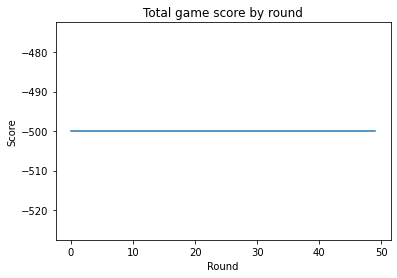

In [6]:
plt.plot(scores)
plt.xlabel('Round')
plt.ylabel('Score')
plt.title('Total game score by round')
plt.show()